In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

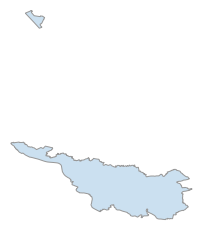

{'init': 'epsg:4326'}


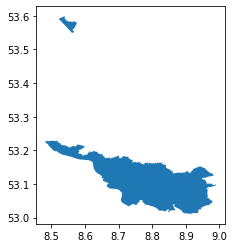

time: 626 ms


In [2]:
city = ox.gdf_from_place('Bremen, Germany')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

574
data max index: 573
number of NA prices: 0
average bedroom price 45.17627773622538
pointinpoly length: 411
check contains: True
check if there are NAs: False


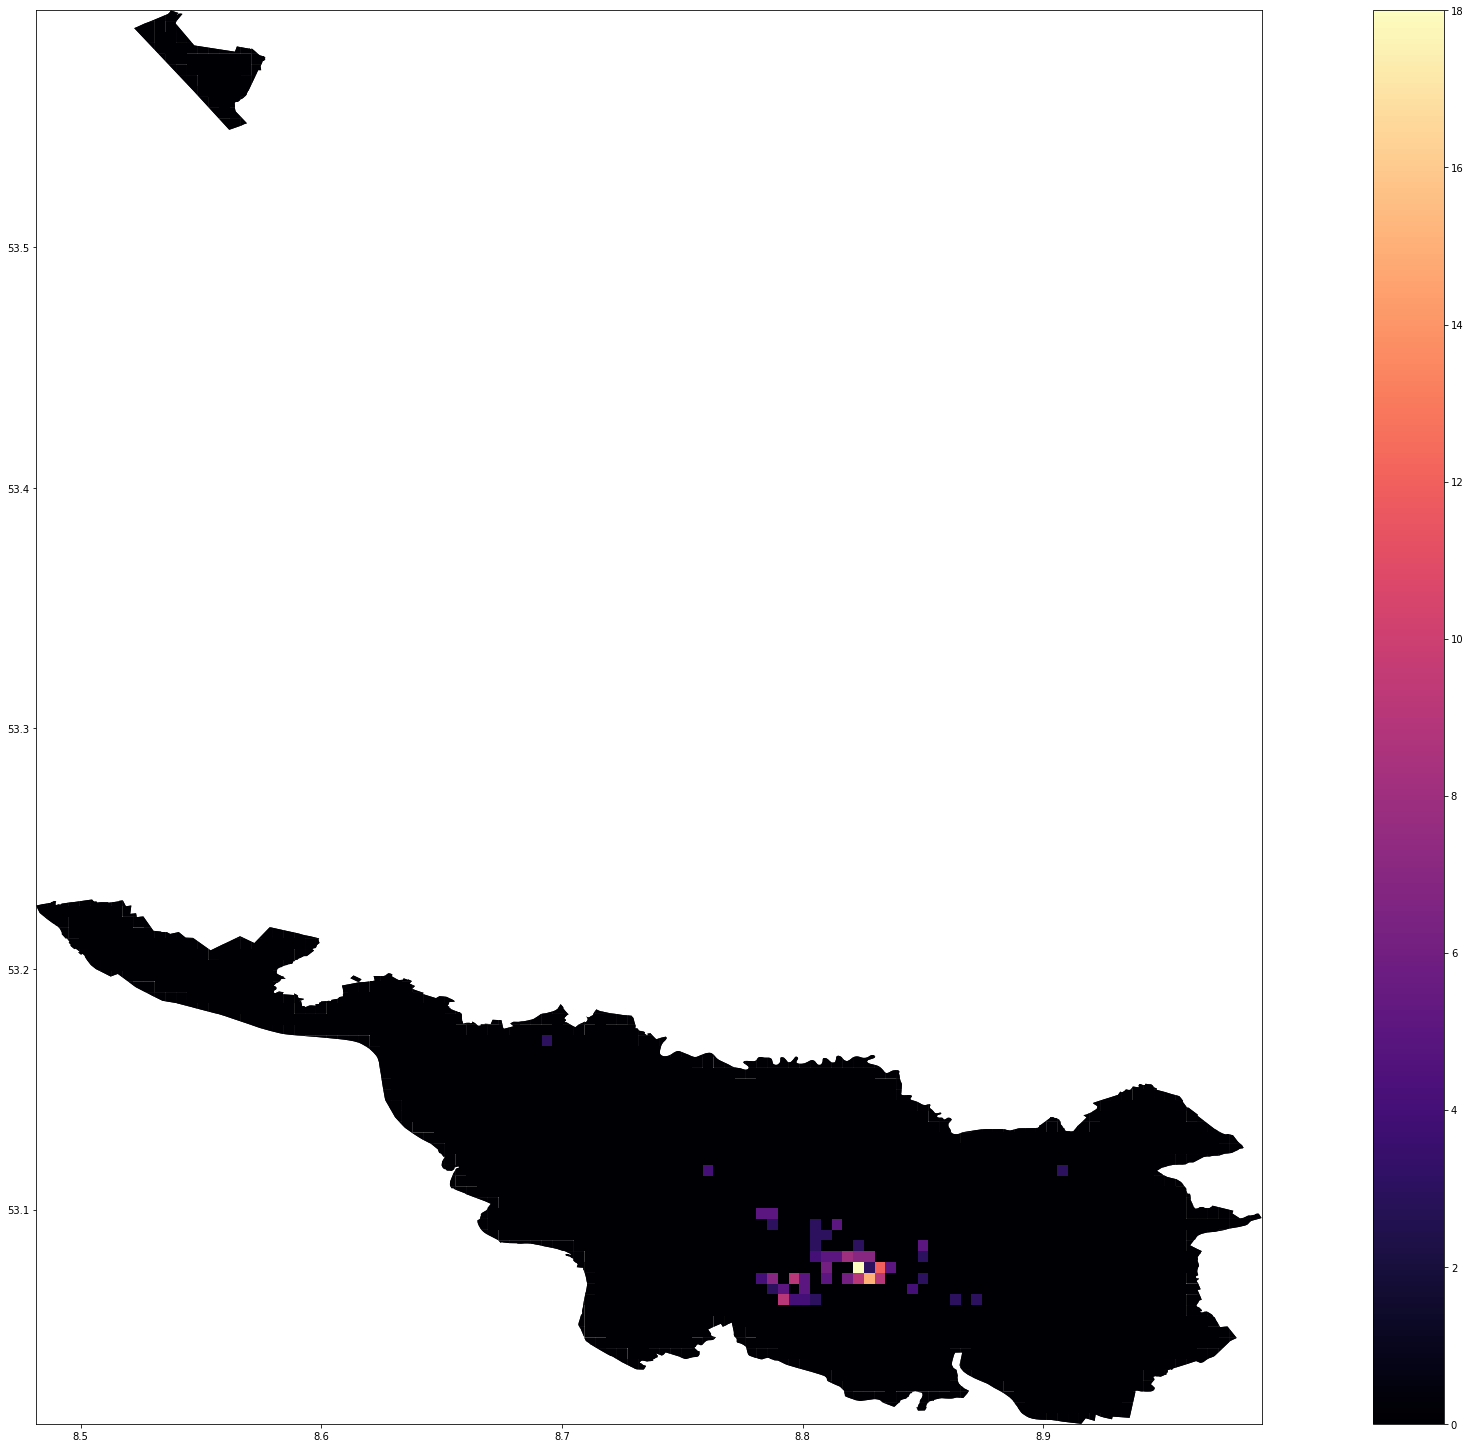

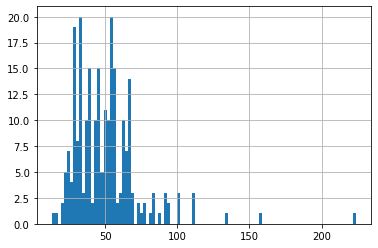

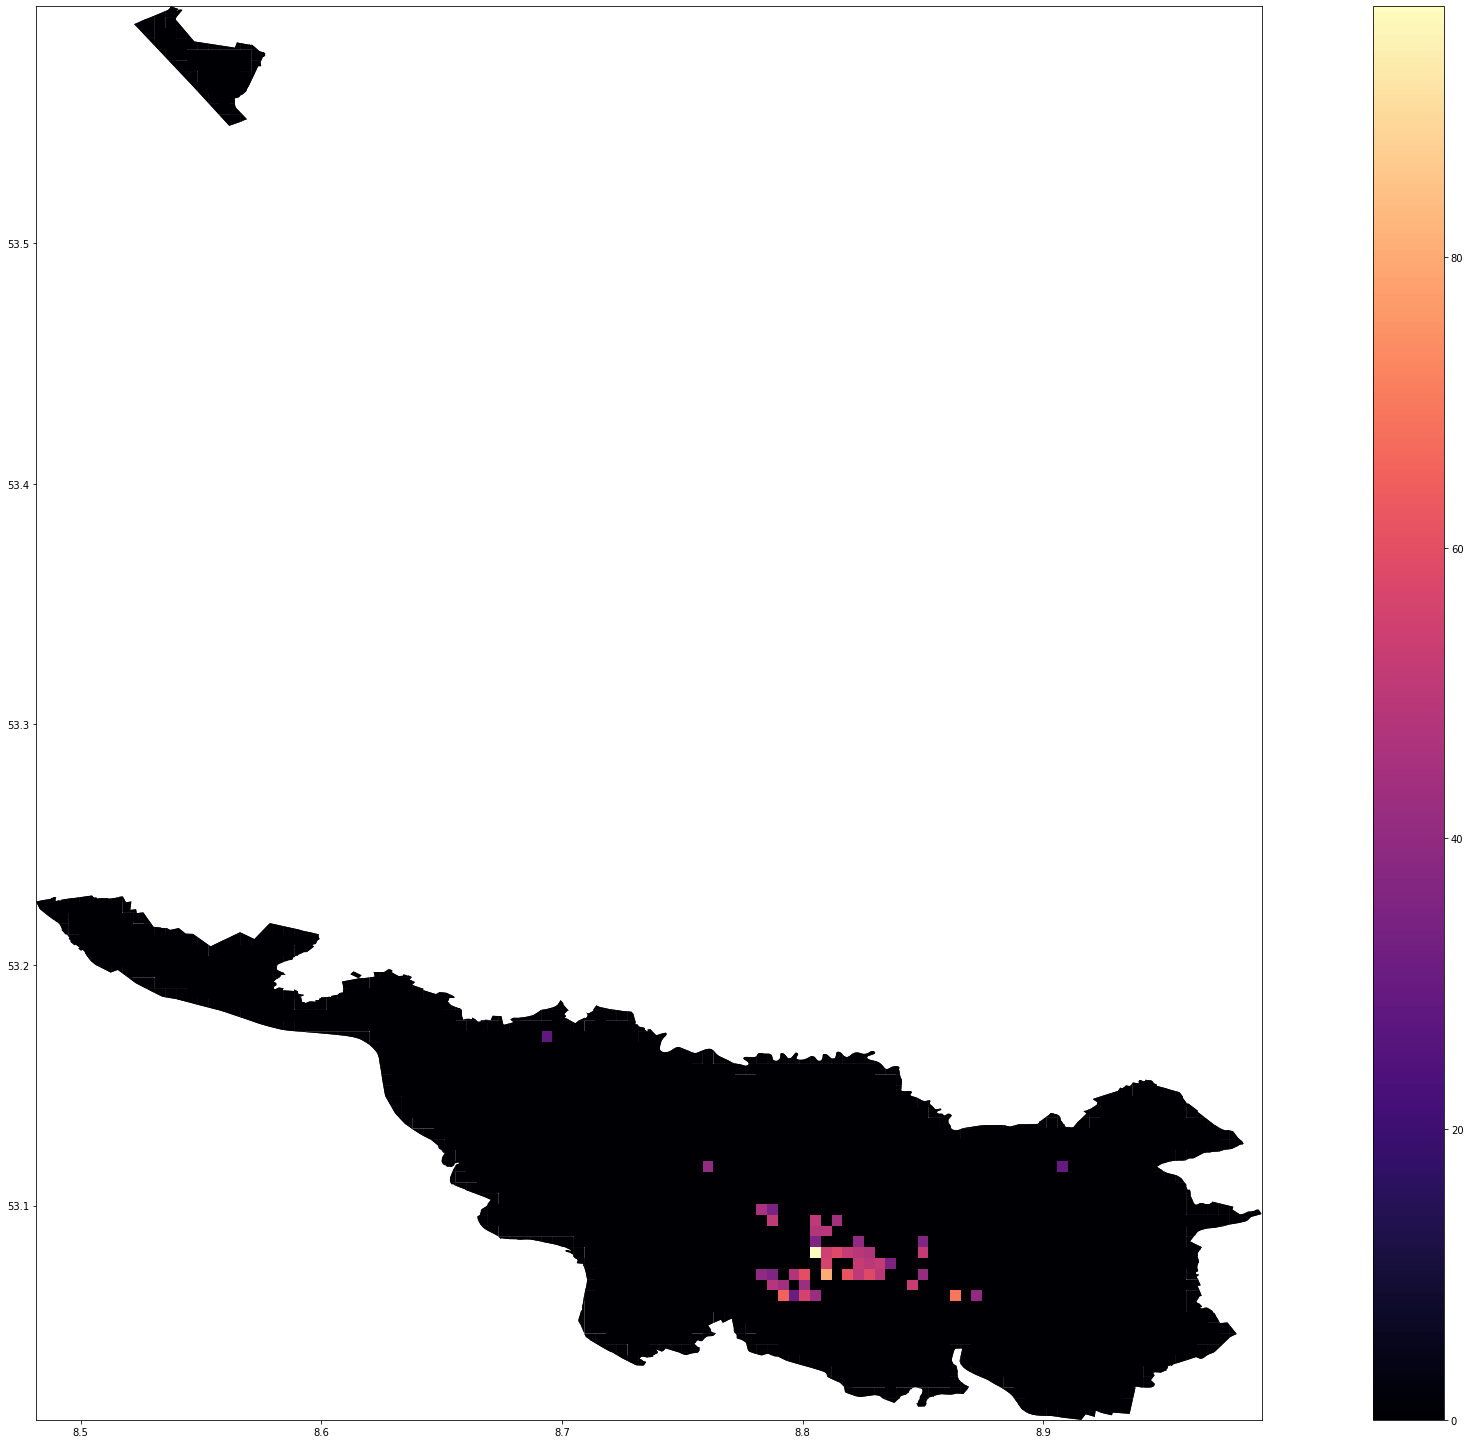

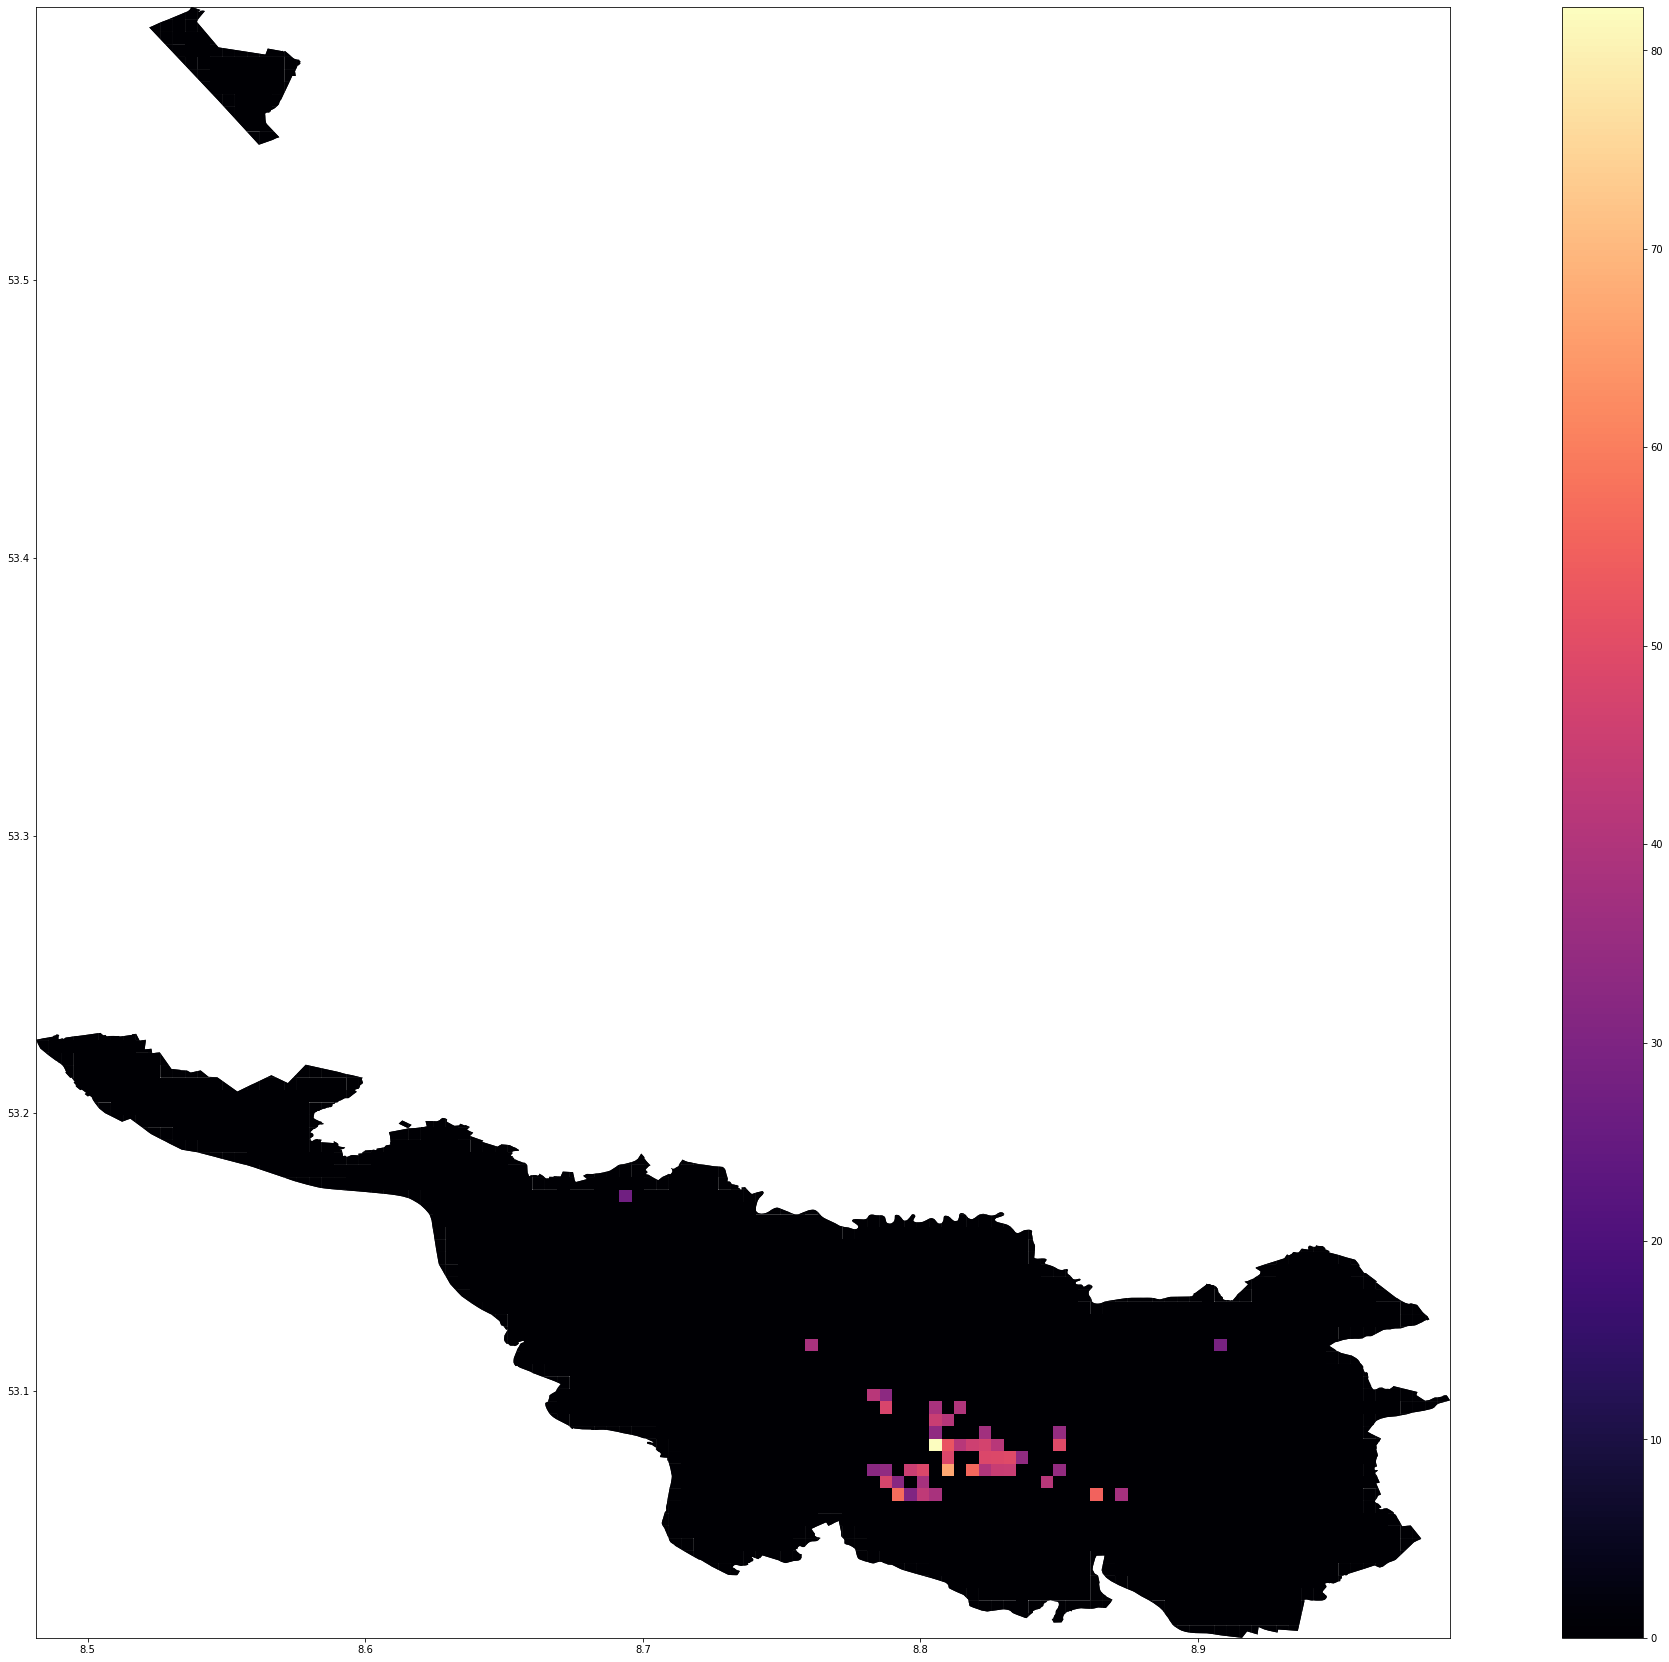

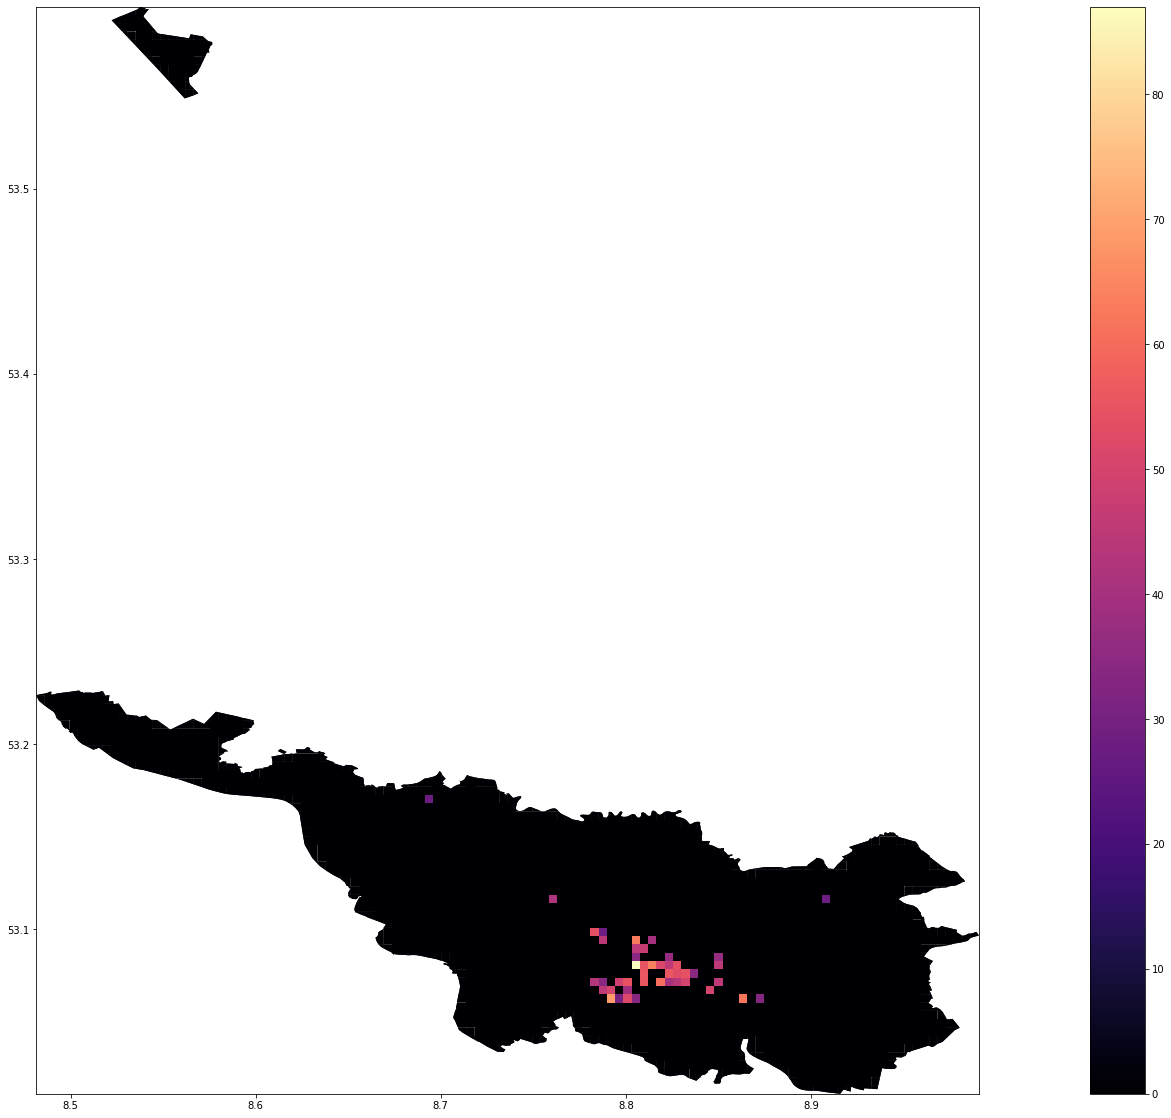

time: 18.4 s


In [3]:
data = pd.read_csv('data/Airbnb_Bremen.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>2]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


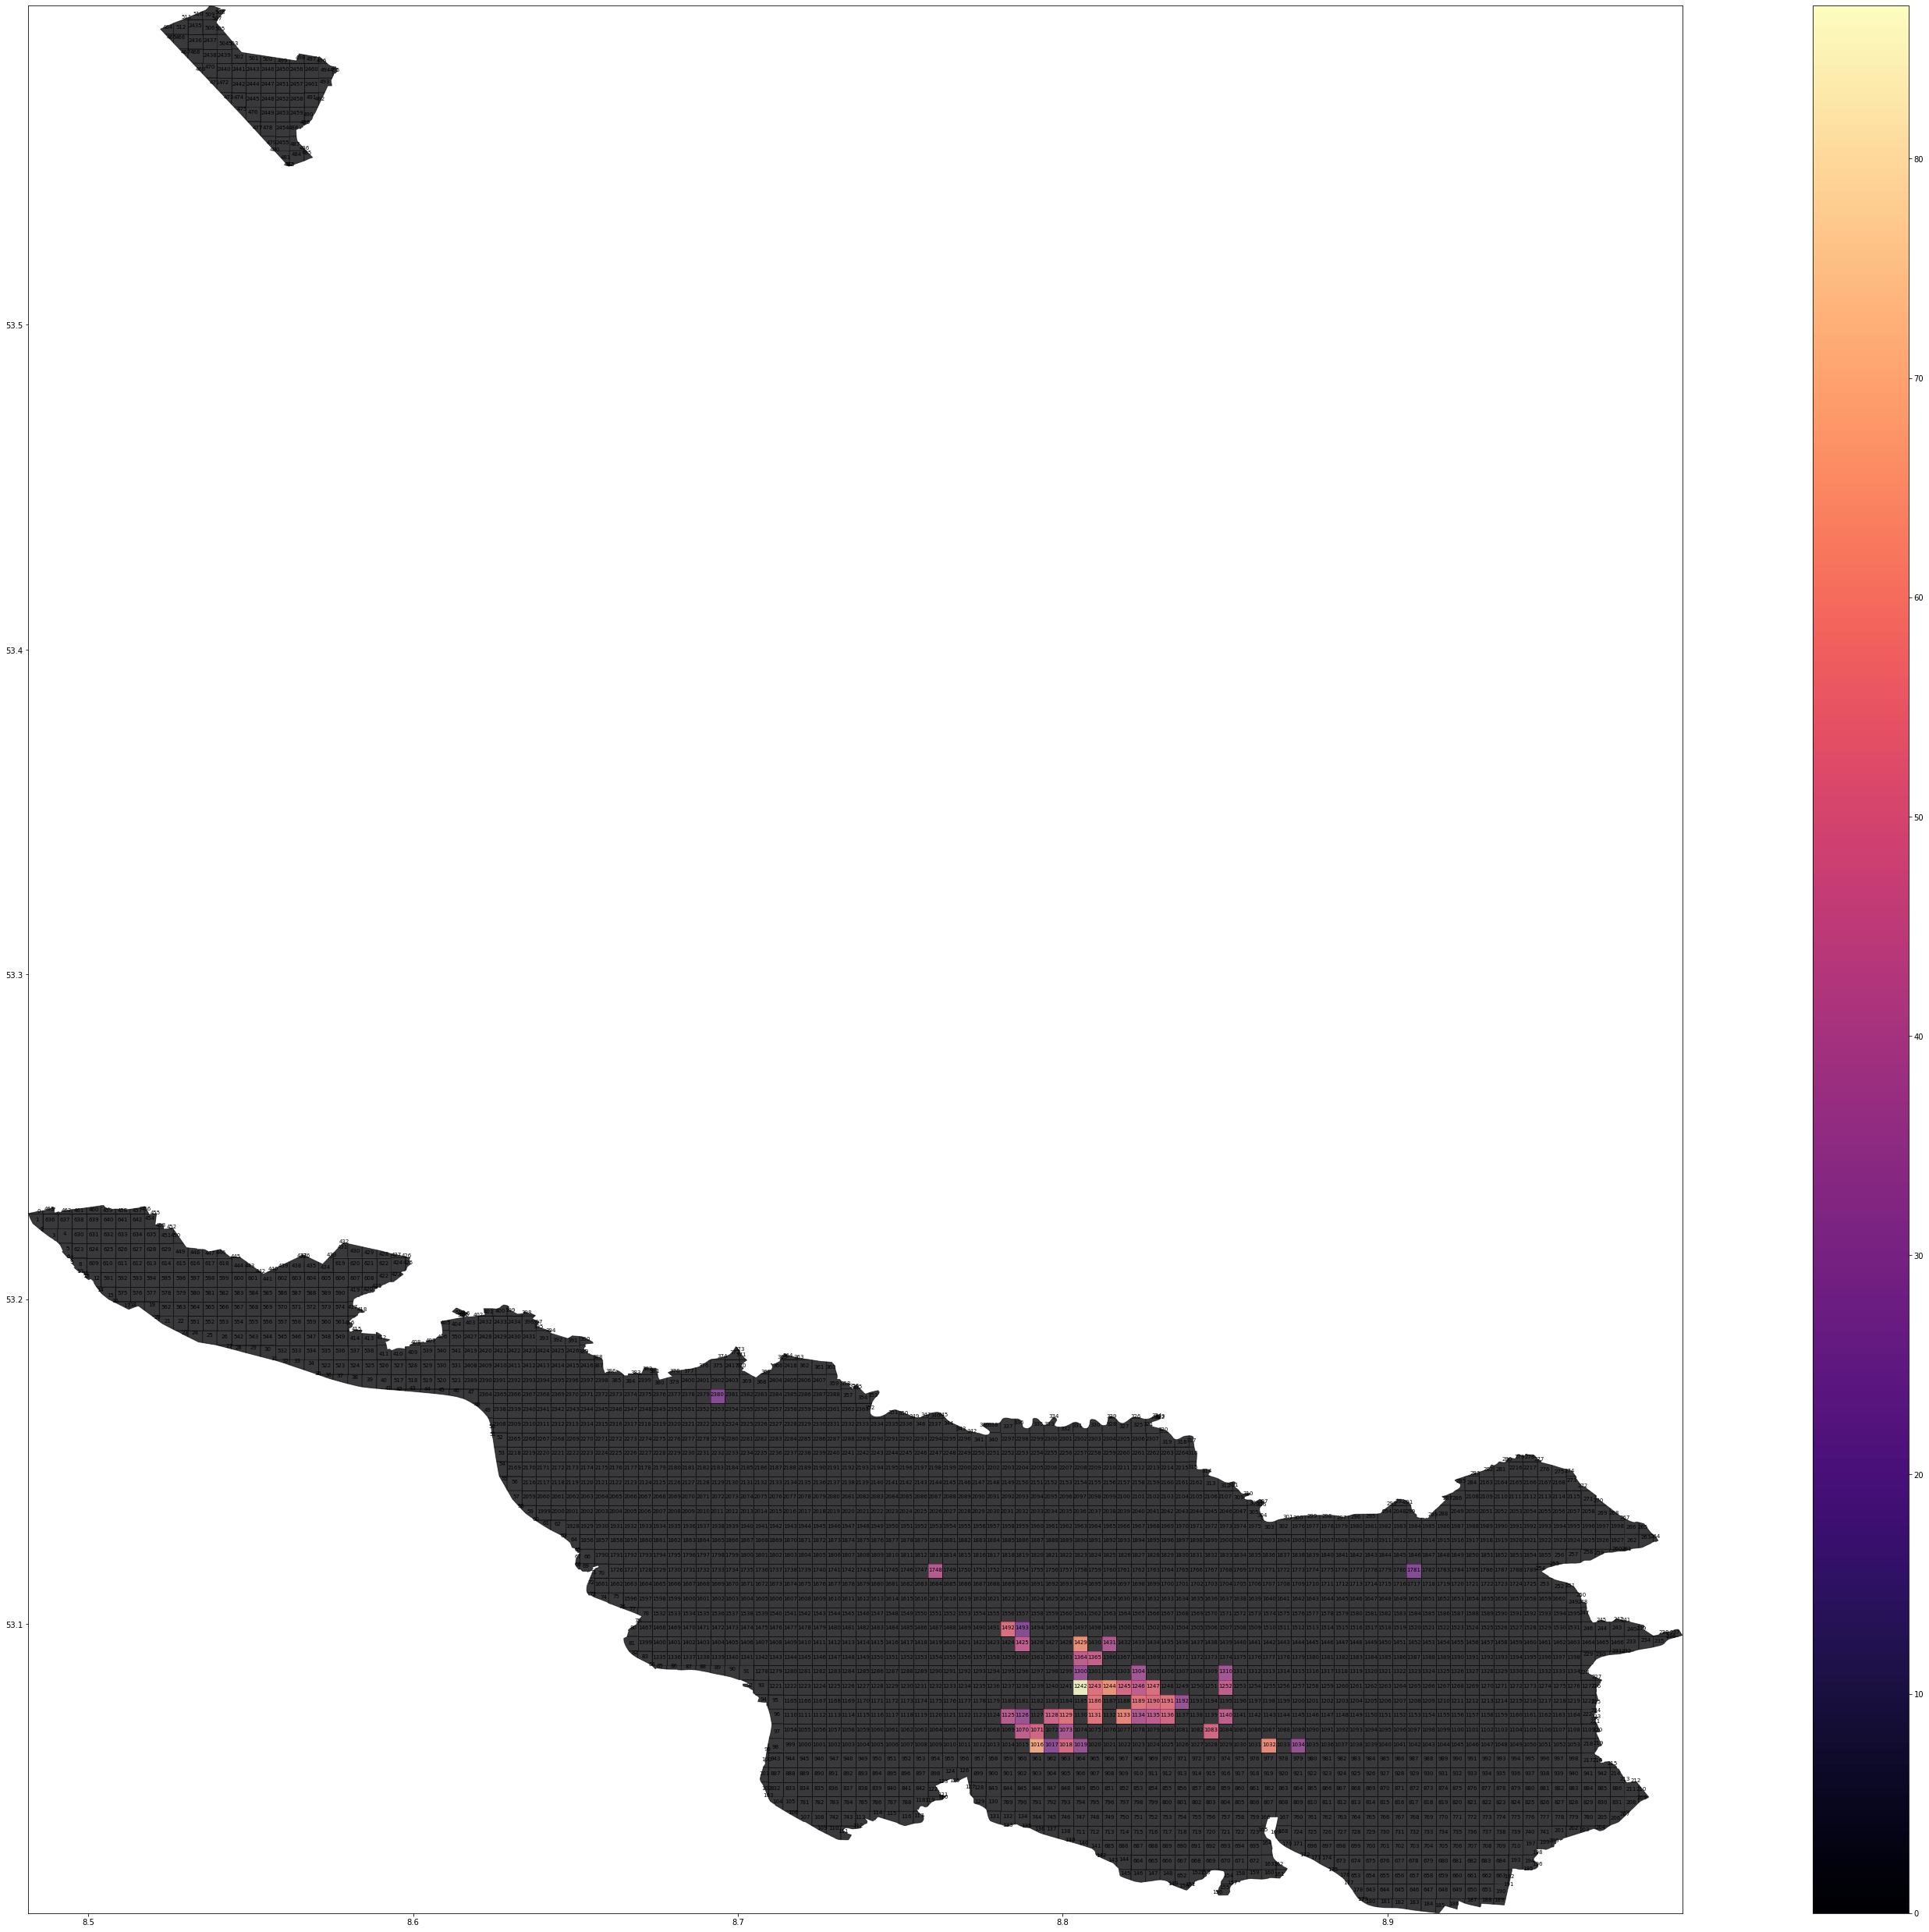

time: 22.8 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(60,45))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

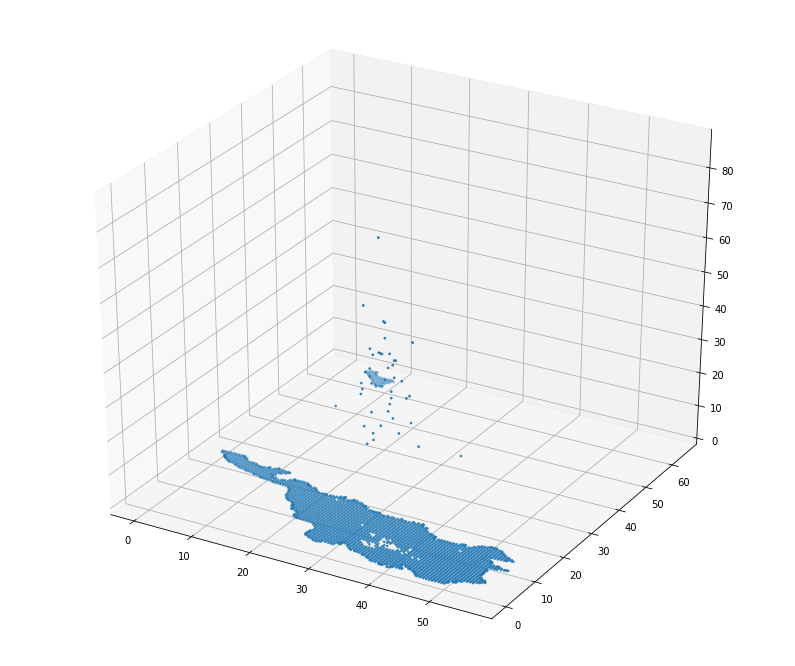

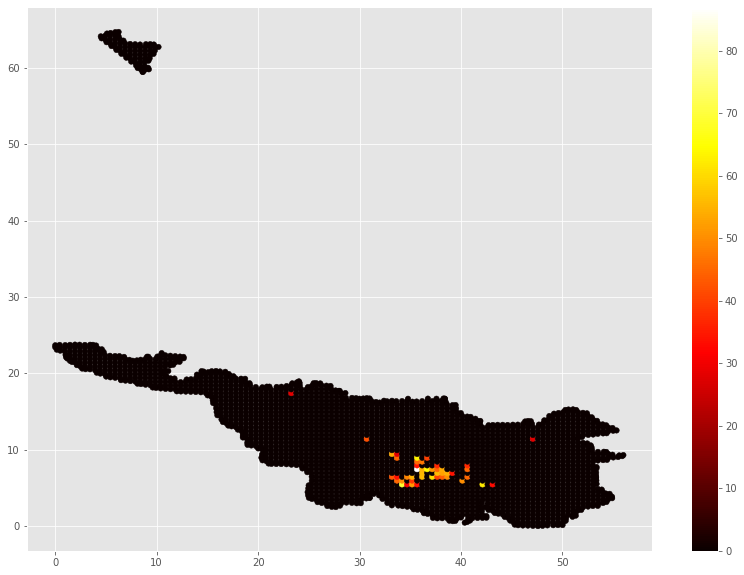

time: 2.61 s


In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Bremen_observed.jpg')
plt.show()

In [6]:
polyair[polyair.median_prices==polyair.median_prices.max()]

geometry  center_lon  \
1242  POLYGON ((8.803154310530816 53.07829418092053,...    8.805387   

      center_lat  count  prices  hmean_prices  median_prices  
1242   53.080536      4   97.25     82.188837           87.0

time: 19.3 ms


In [7]:
cdf = polyair[polyair.index.isin([1242, 1016, 1492])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
1016  POLYGON ((8.789755918425554 53.06035885267625,...    8.791989   
1242  POLYGON ((8.803154310530816 53.07829418092053,...    8.805387   
1492  POLYGON ((8.780823657022044 53.0962295091648, ...    8.783057   

      center_lat  count     prices  hmean_prices  median_prices  cen_lon_km  \
1016   53.062601      9  65.000000     57.089006           69.0   34.188317   
1242   53.080536      4  97.250000     82.188837           87.0   35.677146   
1492   53.098471      5  45.433333     41.486241           54.0   33.195764   

      cen_lat_km  
1016    5.460217  
1242    7.453190  
1492    9.446164

time: 303 ms


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning:

overflow encountered in power



Fitted parameters:
[ 3.87847222e+01  3.44123546e+01  6.01938166e+00  5.91560146e-01
  9.83299479e-01  1.98357619e+00  1.72996522e+02  4.34736842e+01
  3.71801246e+01  6.97288086e+00  6.38072271e-01  1.45746214e+00
  1.71215247e+00  7.51985584e+01  2.15730873e+02  3.35157835e+01
  9.27747951e+00 -1.40554448e-01  2.54135169e-01  2.34921901e+00
  1.74464599e+00]
RMS residual = 4.24820006279823


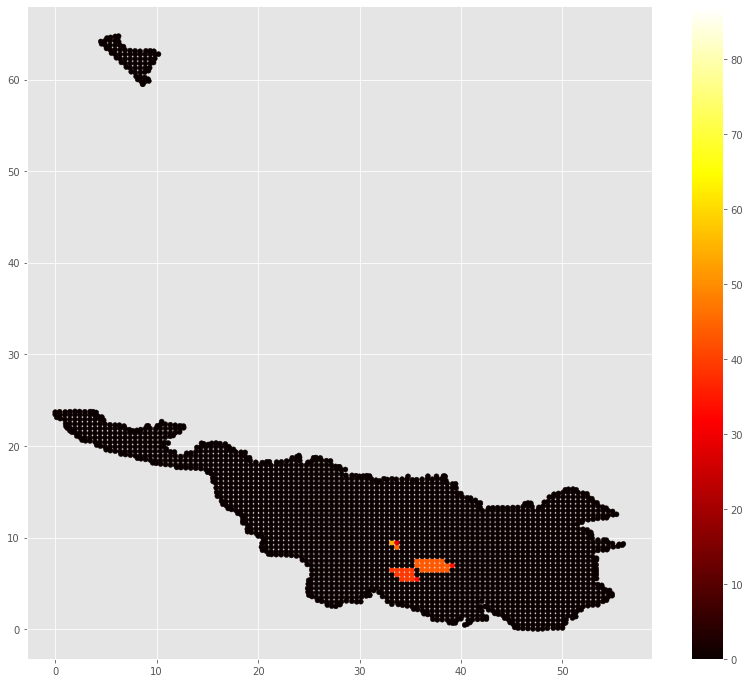

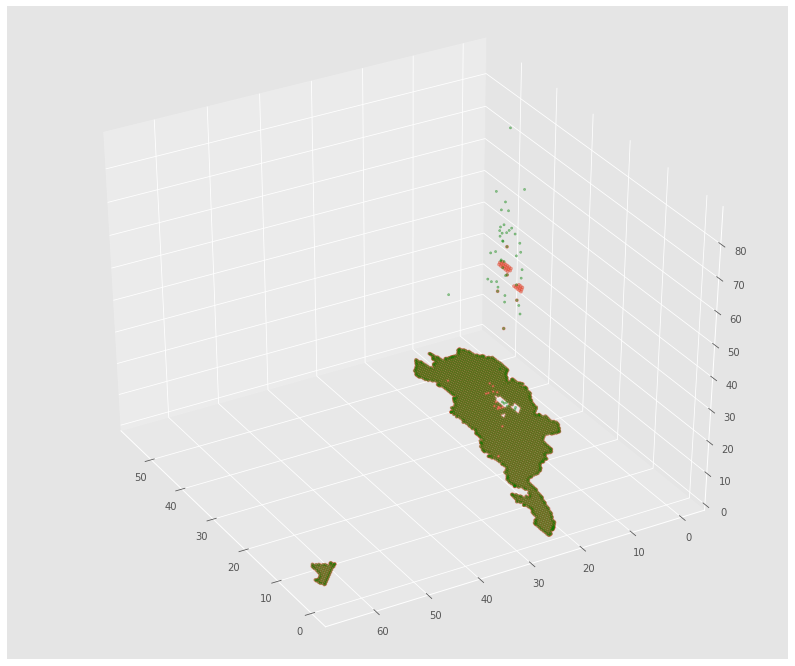

{'Bremen': 83.31324221168109}
time: 2.45 s


In [8]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(69,34.188317,5.460217, 1.5, 2,1.5, 1.4),
              (87,35.677146, 7.453190, 2, 1,1.87, 1.5),
              (54,33.195764,9.446164, 1, 0.5,1.87, 0.7),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bremen_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Bremen'] = np.mean(popt[6::7])
print(alphas)

In [9]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Bremen'] = 1.74464599
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 4.76402612e+01  3.44630616e+01  5.87519966e+00  4.97126930e-01
  9.32983493e-01  1.83886355e+00  5.37097001e+01  3.73396627e+01
  7.15388250e+00  5.69595244e-01  1.57787384e+00  1.86837273e+00
  4.08540293e+02  3.35011668e+01  9.29274915e+00 -1.96773432e-01
  1.05513847e-01  8.47115838e-01]
RMS residual = 4.680400595514814


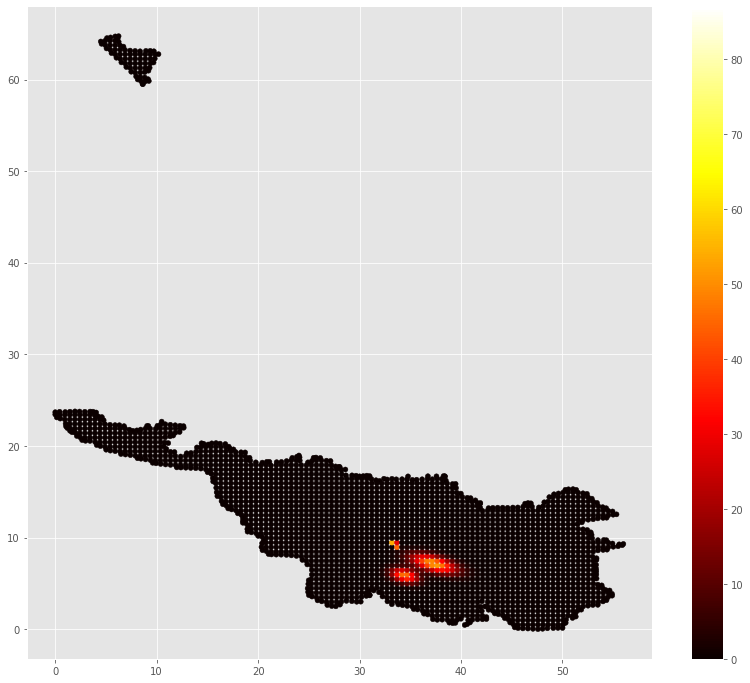

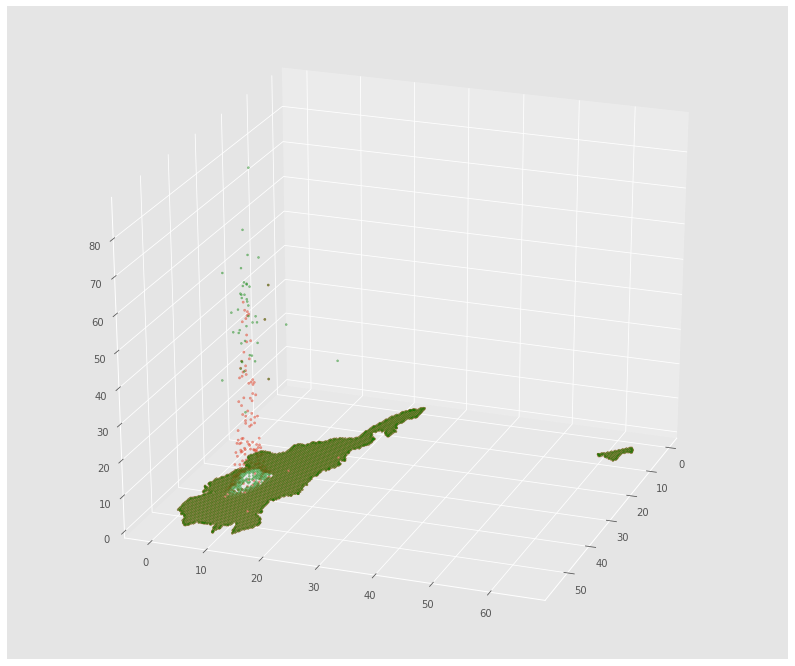

time: 3.19 s


In [10]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr



guess_prms = [(69,34.188317,5.460217, 1.5, 2,1.5),
              (87,35.677146, 7.453190, 2, 1,1.87),
              (54,33.195764,9.446164, 1, 0.5,1.87),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bremen_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
long stds:  [0.02985682 0.02311351 0.01640366] mean:  0.023124662921554212
short stds:  [0.01590878 0.00834373 0.00879597] mean:  0.011016158209218004
time: 30.2 ms


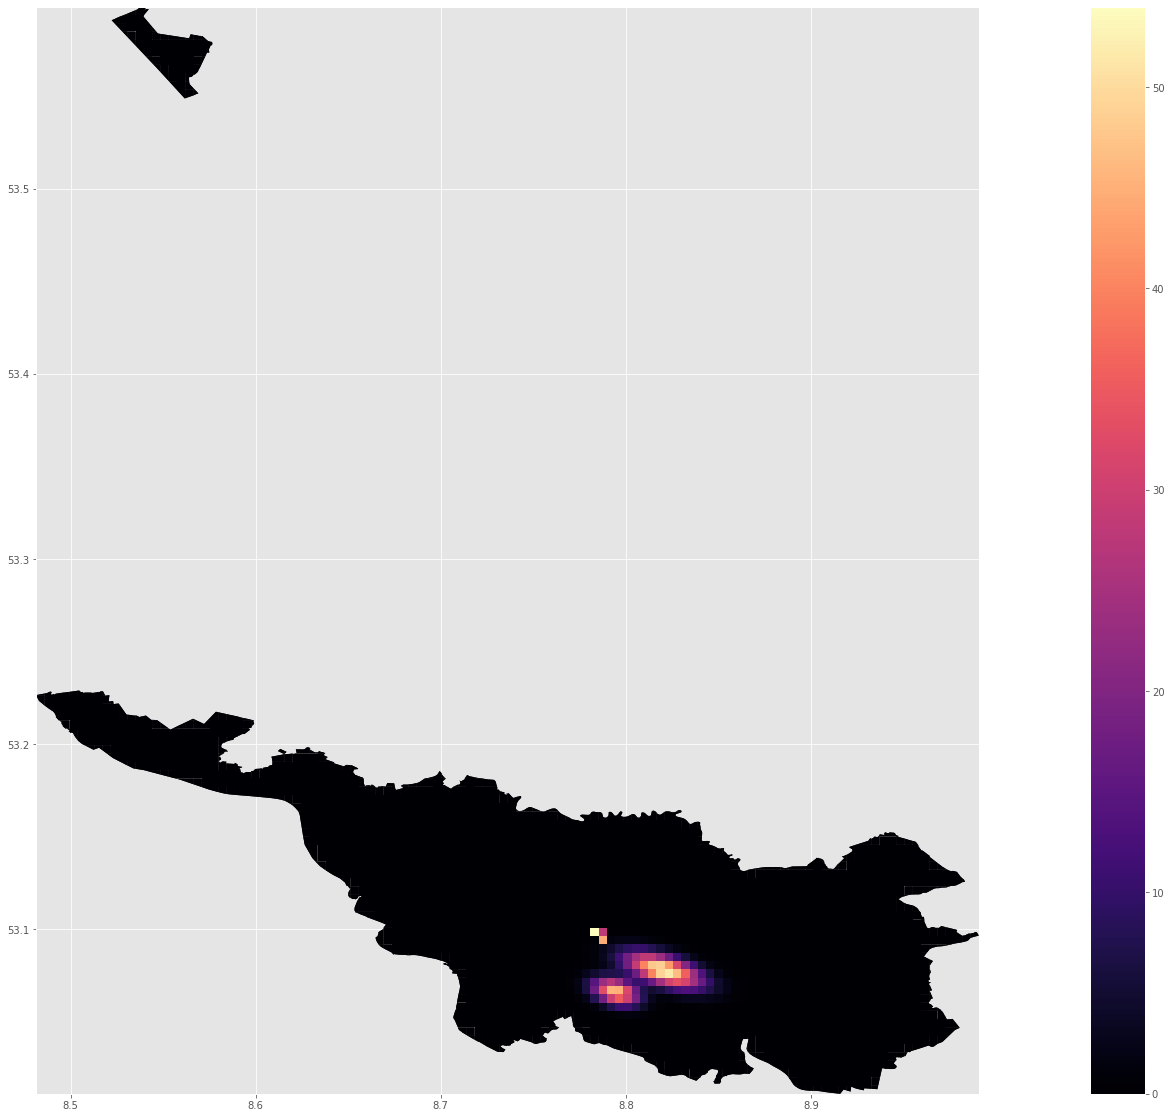

time: 1.87 s


In [12]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [13]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Bremen'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Bremen'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Bremen'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

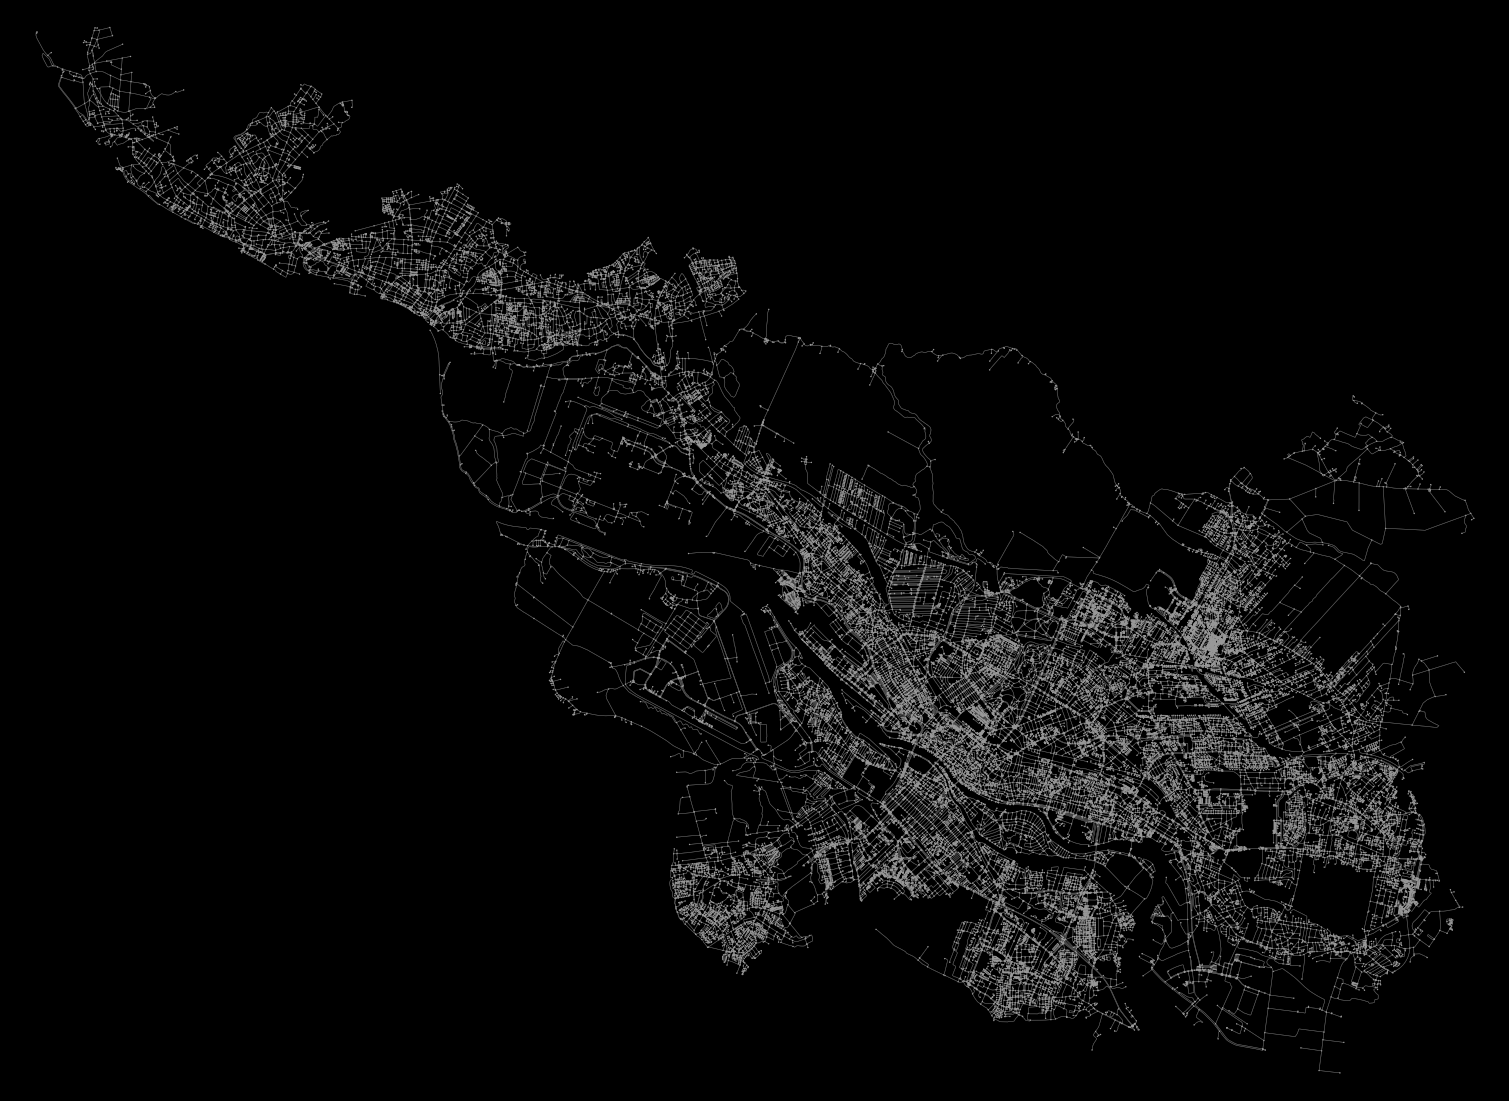

time: 2min 4s


In [14]:
# download and project a street network
G = ox.graph_from_place('Bremen, Germany', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [15]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 772448730,
 'center_node_2': 25747448,
 'center_node_3': 259515650}

time: 727 ms


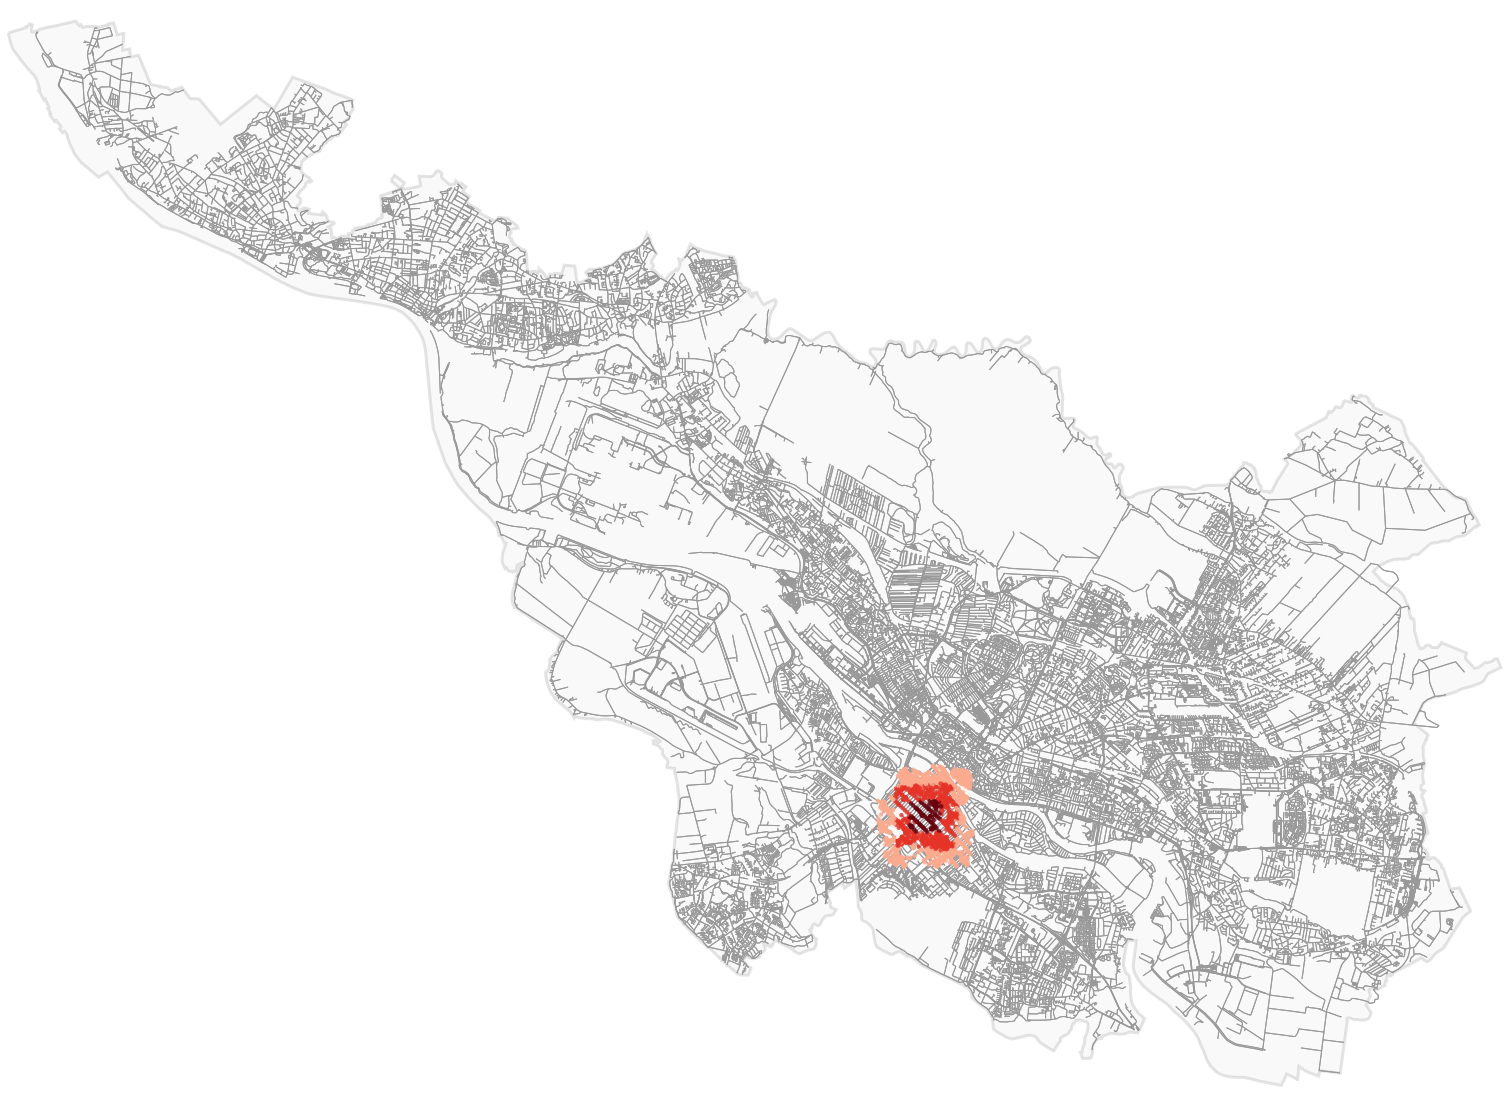

time: 26.4 s


In [16]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

2462
2462 145
Number of cells with price above 5th percentile:  145



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


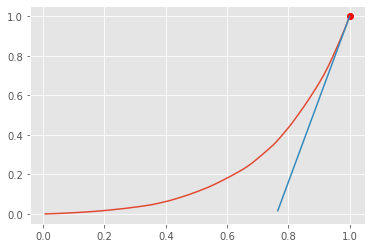

Loubar price:  22.596332334687997
Average price:  13.092293255691496
average city distance:  3495.925661234734
eta =  0.7237739392983955
time: 2.57 s


In [24]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.01*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.01*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [25]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Bremen'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 5 ms


In [26]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Bremen'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345}

time: 6.01 ms


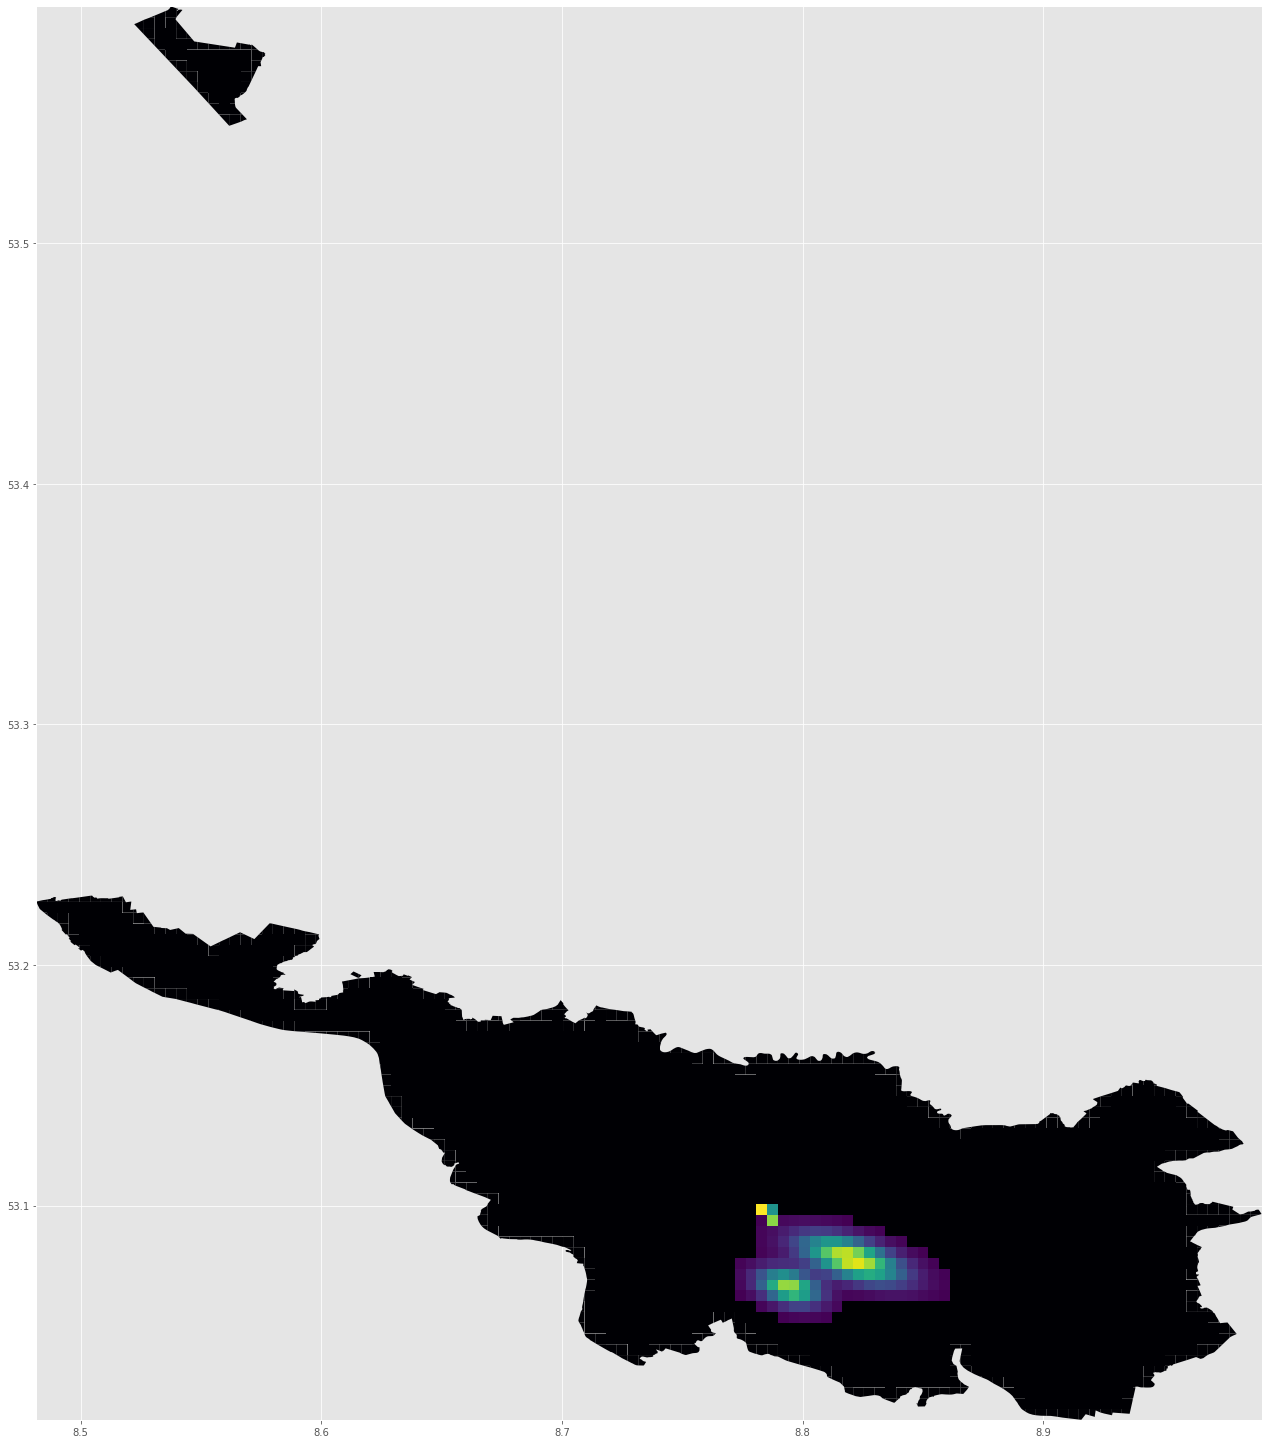

time: 1.02 s


In [27]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [28]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

2462
145



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 2.58 s


2462


2462 145
Number of cells with price above 1.0th percentile:  145
Loubar price:  22.596332334687997
Average price:  13.092293255691496
eta =  0.7237739392983955
2462 132
Number of cells with price above 2.0th percentile:  132
Loubar price:  23.834905271593783
Average price:  14.303724140425176
eta =  0.752750035490757
2462 120
Number of cells with price above 3.0th percentile:  120
Loubar price:  24.592295937661486
Average price:  15.603384856625608
eta =  0.7685688605469513
2462 109
Number of cells with price above 4.0th percentile:  109
Loubar price:  27.996849099959935
Average price:  16.9820826984868
eta =  0.7791486356521621
2462 100
Number of cells with price above 5.0th percentile:  100
Loubar price:  28.379088870278036
Average price:  18.28809620579076
eta =  0.8414673773911523
2462 95
Number of cells with price above 6.000000000000001th percentile:  95
Loubar price:  28.715802360522776
Average price:  19.094169130602413
eta =  0.8656215450504599
2462 94
Number of cells with pri

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
2462 7
Number of cells with price above 84.00000000000001th percentile:  7
Loubar price:  51.54745756675194
Average price:  48.96916581352916
eta =  nan
2462 6
Number of cells with price above 85.0th percentile:  6
Loubar price:  51.54745756675194
Average price:  49.555420682564396
eta =  nan
2462 5
Number of cells with price above 86.0th percentile:  5
Loubar price:  51.54745756675194
Average price:  50.183297785028415
eta =  nan
2462 5
Number of cells with price above 87.0th percentile:  5
Loubar price:  51.54745756675194
Average price:  50.183297785028415
eta =  nan
2462 5
Number of cells with price above 88.0th percentile:  5
Loubar price:  51.54745756675194
Average price:  50.183297785028415
eta =  nan
2462 4
Number of cells with price above 89.0th percentile:  4
Loubar price:  53.997993250465356
Average price:  50.806935539977495
eta =  nan
2462 4
Number of cells with price above 90.0th percentile:  4
Loubar price:  53.997993250465356
Average price:  50.806935539977495

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  53.997993250465356
Average price:  53.997993250465356
eta =  nan
2462 1
Number of cells with price above 97.0th percentile:  1
Loubar price:  53.997993250465356
Average price:  53.997993250465356
eta =  nan
2462 1
Number of cells with price above 98.0th percentile:  1
Loubar price:  53.997993250465356
Average price:  53.997993250465356
eta =  nan
2462 1
Number of cells with price above 99.0th percentile:  1
Loubar price:  53.997993250465356
Average price:  53.997993250465356
eta =  nan
2462 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  53.997993250465356
Average price:  53.997993250465356
eta =  nan



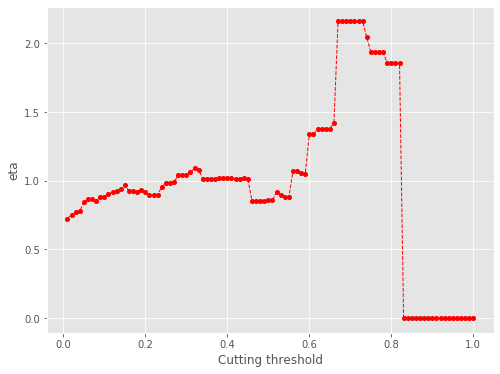

time: 1.79 s


In [29]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [30]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Bremen'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 32 ms


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


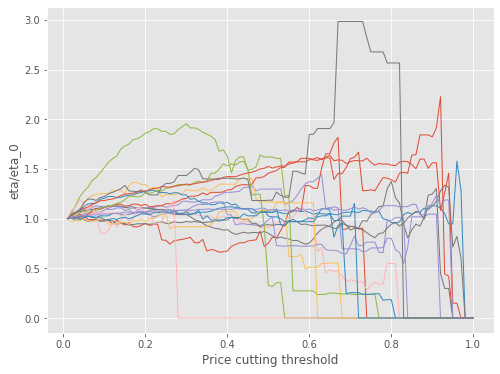

time: 230 ms


In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

2462 145
Number of cells with price above 5th percentile:  145


eta =  1.0
eta =  0.9950332094255996
eta =  0.9443275635273443
eta =  0.9273516706090156
eta =  0.8911106376090171
eta =  0.8473715726303439
eta =  0.8361492789264972
eta =  0.8321980339452536
eta =  0.821854443701653
eta =  0.8097110833226441
eta =  0.8036535765987268
eta =  0.8017392370161031
eta =  0.779535665489338
eta =  0.7764691289840618
eta =  0.7662658828435922
eta =  0.7640766902035646
eta =  0.7640766902035646
eta =  0.7662939198281062
eta =  0.7561217482318615
eta =  0.7547538398336422
eta =  0.7560116032387307
eta =  0.7554107088667839
eta =  0.7555966407396779
eta =  0.7555966407396779
eta =  0.7477295578567136
eta =  0.7297915948572884
eta =  0.7297915948572884
eta =  0.7212193779106397
eta =  0.727153958294649
eta =  0.727153958294649
eta =  0.727153958294649
eta =  0.7248683742803003
eta =  0.7240520406391644
eta =  0.7301717600803742
eta =  0.7244487205882567
eta =  0.7244487205882567
eta =  0.7244487205882567
eta =  0.7244487205882567
eta =  0.7206700690633342
eta = 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



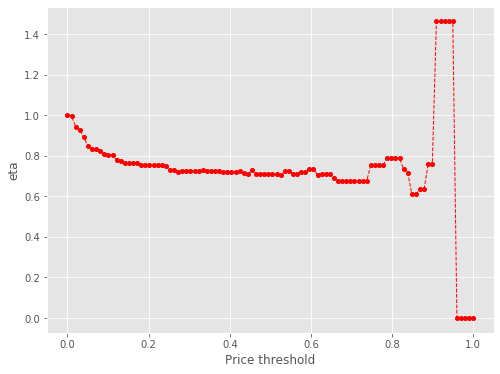

time: 572 ms


In [32]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.01*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.01*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [33]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Bremen'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 27 ms


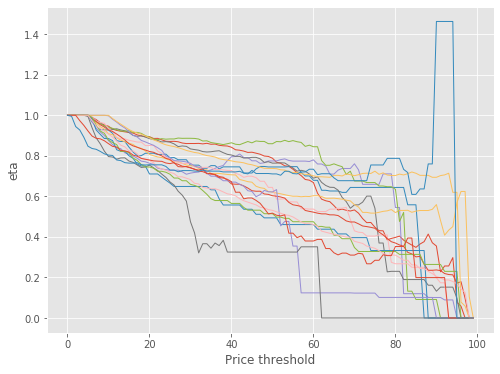

time: 195 ms


In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

2462 145
Number of cells with price above 1.0th percentile:  145


eta =  1.0
eta =  0.9443275635273443
eta =  0.9273516706090156
eta =  0.8911106376090171
eta =  0.8473715726303439
eta =  0.8361492789264972
eta =  0.8360763192535705
eta =  0.8328423774930902
eta =  0.8097110833226441
eta =  0.8036535765987268
eta =  0.8017392370161031
eta =  0.7870041868260448
eta =  0.7764691289840618
eta =  0.7701976083472444
eta =  0.7601569758335383
eta =  0.7640766902035646
eta =  0.766182672393232
eta =  0.768004540406848
eta =  0.7635838100156556
eta =  0.7560116032387307
eta =  0.7554107088667839
eta =  0.7555966407396779
eta =  0.7555966407396779
eta =  0.7477295578567136
eta =  0.7297915948572884
eta =  0.7297915948572884
eta =  0.7212193779106397
eta =  0.727153958294649
eta =  0.727153958294649
eta =  0.727153958294649
eta =  0.7118919164559079
eta =  0.7218879528021876
eta =  0.7301717600803742
eta =  0.7228097781918617
eta =  0.7244487205882567
eta =  0.7244487205882567
eta =  0.7244487205882567
eta =  0.7206700690633342
eta =  0.7206700690633342
eta = 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


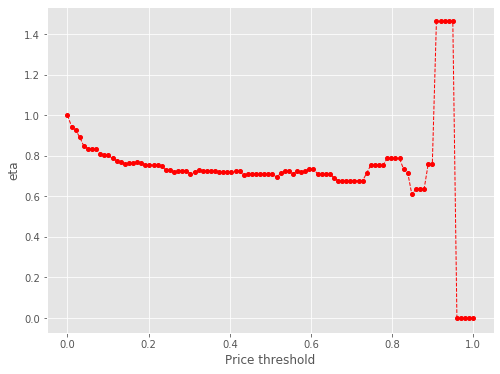

2462 132
Number of cells with price above 2.0th percentile:  132


eta =  1.0
eta =  0.9820233004160985
eta =  0.9436456924760872
eta =  0.8973280092187069
eta =  0.8854441098841073
eta =  0.885366848904184
eta =  0.8819422514600508
eta =  0.8574472615181667
eta =  0.8510326370193428
eta =  0.8490054383474401
eta =  0.8334016894374554
eta =  0.8235717470454892
eta =  0.8156042861550363
eta =  0.8049717123517245
eta =  0.8091225118427243
eta =  0.8113526513314001
eta =  0.8132819268116273
eta =  0.8086005741095207
eta =  0.8044520137421214
eta =  0.7999456312014236
eta =  0.7999522346430158
eta =  0.8001425246101043
eta =  0.7918116411467662
eta =  0.7728161530425944
eta =  0.7728161530425944
eta =  0.7728161530425944
eta =  0.7700230157197919
eta =  0.7700230157197919
eta =  0.7700230157197919
eta =  0.7700230157197919
eta =  0.7676026860559925
eta =  0.7667382258065355
eta =  0.7654227262963205
eta =  0.7671582918560858
eta =  0.7671582918560858
eta =  0.7671582918560858
eta =  0.7671582918560858
eta =  0.7631568715112129
eta =  0.7631568715112129
et

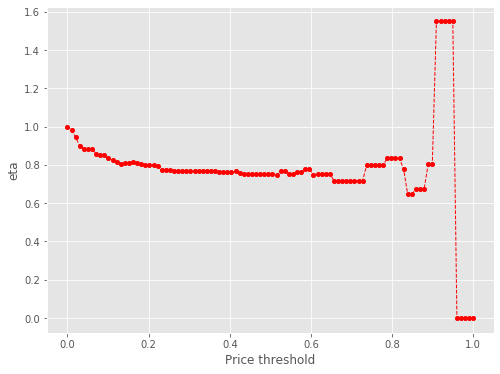

2462 120
Number of cells with price above 3.0th percentile:  120


eta =  1.0
eta =  0.9609198601257729
eta =  0.9137542956857491
eta =  0.9016528523395838
eta =  0.9015741770373884
eta =  0.8980868896759966
eta =  0.8811186368077544
eta =  0.8666114507249951
eta =  0.864547142606192
eta =  0.859200509029048
eta =  0.8386478678220048
eta =  0.8305345563689294
eta =  0.8202597959802258
eta =  0.8239341281412432
eta =  0.8239341281412432
eta =  0.828169684433177
eta =  0.8170463877441855
eta =  0.8191781329437525
eta =  0.8145892575690151
eta =  0.8145959818917368
eta =  0.8147897552645355
eta =  0.8063063685059848
eta =  0.8012128185695742
eta =  0.7869631532318431
eta =  0.7869631532318431
eta =  0.7841188853599718
eta =  0.7841188853599718
eta =  0.7841188853599718
eta =  0.7841188853599718
eta =  0.7816542496809874
eta =  0.7807739648149454
eta =  0.787373100434328
eta =  0.7812017204999401
eta =  0.7812017204999401
eta =  0.7812017204999401
eta =  0.7812017204999401
eta =  0.7771270510463972
eta =  0.7771270510463972
eta =  0.7771270510463972
eta =

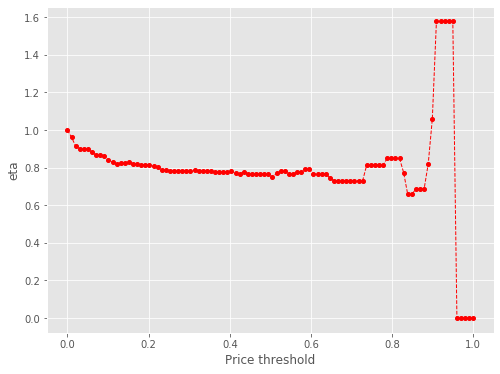

2462 109
Number of cells with price above 4.0th percentile:  109


eta =  1.0
eta =  0.9509162351646574
eta =  0.9383226320471391
eta =  0.938240757058953
eta =  0.9346116434292948
eta =  0.9045132768782657
eta =  0.9018561137986743
eta =  0.8997078512801611
eta =  0.8941437727352092
eta =  0.872755265680778
eta =  0.8643119898263133
eta =  0.8536193599670878
eta =  0.8574431254167232
eta =  0.8574431254167232
eta =  0.8599312896591464
eta =  0.8502752639926122
eta =  0.8524937062249207
eta =  0.8461735460841625
eta =  0.8477252013348086
eta =  0.8479268553757326
eta =  0.8390984534344509
eta =  0.8337977513178936
eta =  0.8189685590730106
eta =  0.8189685590730106
eta =  0.8093488591335628
eta =  0.8160086162204412
eta =  0.8160086162204412
eta =  0.8160086162204412
eta =  0.813443745016029
eta =  0.8125276593958121
eta =  0.8193951786273522
eta =  0.8129728116949213
eta =  0.8129728116949213
eta =  0.8129728116949213
eta =  0.8129728116949213
eta =  0.8087324274312331
eta =  0.8087324274312331
eta =  0.8087324274312331
eta =  0.8087324274312331
eta 

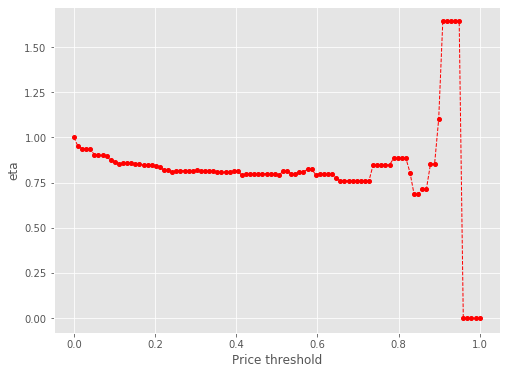

2462 100
Number of cells with price above 5.0th percentile:  100


eta =  1.0
eta =  0.9867563486122016
eta =  0.9866702474550668
eta =  0.9828538086401066
eta =  0.95120184452592
eta =  0.9484075257612065
eta =  0.9461483756499023
eta =  0.9490091750562656
eta =  0.9178045693263978
eta =  0.9036805808700453
eta =  0.8976809190972306
eta =  0.9017020571409755
eta =  0.9017020571409755
eta =  0.9043186537984007
eta =  0.894164209790131
eta =  0.8964971621052467
eta =  0.8898507721215234
eta =  0.8914825196858894
eta =  0.8916945825716274
eta =  0.8916945825716274
eta =  0.8824104820222735
eta =  0.8612415360972365
eta =  0.8612415360972365
eta =  0.8511252928533908
eta =  0.858128808873627
eta =  0.858128808873627
eta =  0.858128808873627
eta =  0.8401177705857057
eta =  0.8519142913437138
eta =  0.8616901766173637
eta =  0.8530021557699565
eta =  0.8549363041994438
eta =  0.8549363041994438
eta =  0.8549363041994438
eta =  0.8504770425874533
eta =  0.8504770425874533
eta =  0.8504770425874533
eta =  0.8504770425874533
eta =  0.8504770425874533
eta =  

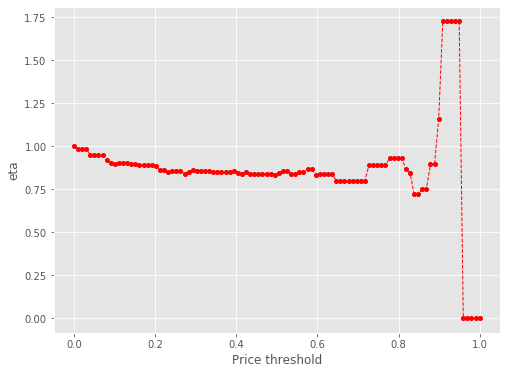

2462 95
Number of cells with price above 6.000000000000001th percentile:  95


eta =  1.0
eta =  0.9952744742107337
eta =  0.9829039675269506
eta =  0.9683810101016935
eta =  0.9611364822684648
eta =  0.9588470112004738
eta =  0.9322924567849374
eta =  0.9286250057895683
eta =  0.9211245261564707
eta =  0.9091163444038093
eta =  0.9138041608844487
eta =  0.9138041608844487
eta =  0.9185017074856084
eta =  0.906165145071228
eta =  0.9085294088719087
eta =  0.9017938150314729
eta =  0.9034474629321537
eta =  0.9036623719986484
eta =  0.8942536658247167
eta =  0.8942536658247167
eta =  0.8728006030146224
eta =  0.8728006030146224
eta =  0.8625485856264662
eta =  0.8696460986347039
eta =  0.8696460986347039
eta =  0.8696460986347039
eta =  0.8513933270024235
eta =  0.8633481735809118
eta =  0.8732552649185038
eta =  0.8644506386704678
eta =  0.8664107460791584
eta =  0.8664107460791584
eta =  0.8664107460791584
eta =  0.8664107460791584
eta =  0.8618916349345865
eta =  0.8618916349345865
eta =  0.8618916349345865
eta =  0.8618916349345865
eta =  0.8656037355286887
et

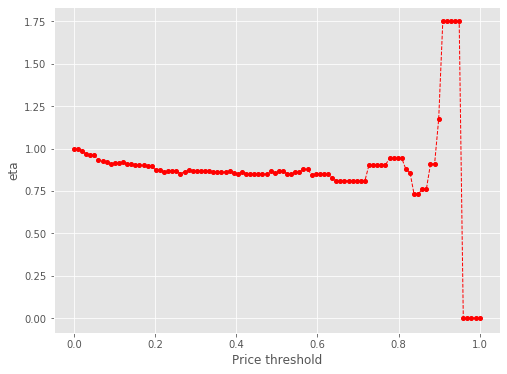

2462 94
Number of cells with price above 6.999999999999999th percentile:  94


eta =  1.0
eta =  0.9961320017251923
eta =  0.9816573319601505
eta =  0.9612203552376775
eta =  0.9589306843804369
eta =  0.9618301327156251
eta =  0.9302039579015428
eta =  0.9153366376519301
eta =  0.909808440472014
eta =  0.9138839034284747
eta =  0.9138839034284747
eta =  0.9165358498758052
eta =  0.9043692911992883
eta =  0.9027331864960233
eta =  0.9042375508418661
eta =  0.9035188432811935
eta =  0.9037412295258608
eta =  0.9037412295258608
eta =  0.8943317023071161
eta =  0.87287676740902
eta =  0.87287676740902
eta =  0.87287676740902
eta =  0.8697219877532654
eta =  0.8697219877532654
eta =  0.8697219877532654
eta =  0.8697219877532654
eta =  0.8669882851453632
eta =  0.8660118986333463
eta =  0.8733314689886859
eta =  0.8664863528667188
eta =  0.8664863528667188
eta =  0.8664863528667188
eta =  0.8664863528667188
eta =  0.8619668473647618
eta =  0.8619668473647618
eta =  0.8619668473647618
eta =  0.8619668473647618
eta =  0.8619668473647618
eta =  0.8656792718929822
eta =  0

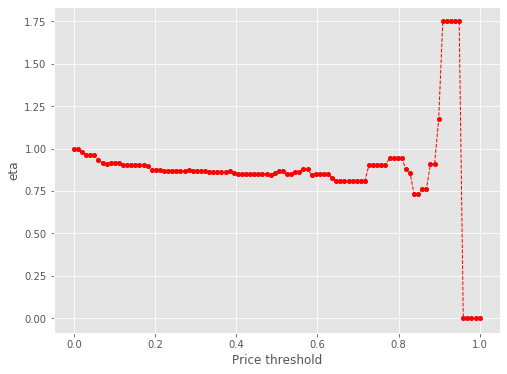

2462 92
Number of cells with price above 8.0th percentile:  92


eta =  1.0
eta =  0.9677958574958562
eta =  0.964952790968414
eta =  0.9626542292785225
eta =  0.965564936223151
eta =  0.9338159564099242
eta =  0.9188909060914281
eta =  0.9133412428235663
eta =  0.9174325308751522
eta =  0.9174325308751522
eta =  0.9200947748776916
eta =  0.9078809732375017
eta =  0.9062385155105824
eta =  0.907748721329929
eta =  0.9070272230150191
eta =  0.9072504727894286
eta =  0.9072504727894286
eta =  0.897804408209184
eta =  0.8762661634173907
eta =  0.8762661634173907
eta =  0.8762661634173907
eta =  0.8659734391537052
eta =  0.8730991336961381
eta =  0.8730991336961381
eta =  0.8730991336961381
eta =  0.8703548160724017
eta =  0.8693746382341977
eta =  0.8767226306113755
eta =  0.8678830445294656
eta =  0.8698509347817945
eta =  0.8698509347817945
eta =  0.8698509347817945
eta =  0.8653138799596126
eta =  0.8653138799596126
eta =  0.8653138799596126
eta =  0.8653138799596126
eta =  0.8653138799596126
eta =  0.8690407198982864
eta =  0.8580649280618282
eta =

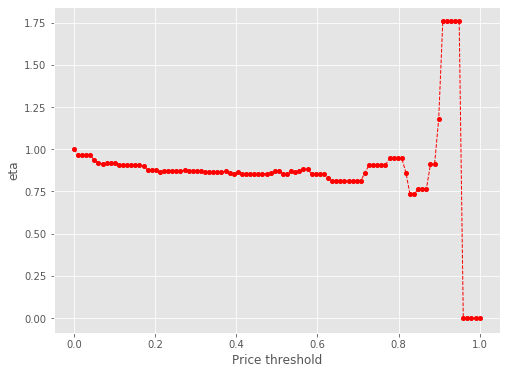

2462 86
Number of cells with price above 9.0th percentile:  86


eta =  1.0
eta =  0.9895052126166091
eta =  0.9901547027443066
eta =  0.9627331051101815
eta =  0.9589459067274044
eta =  0.9463448119040501
eta =  0.943641140575946
eta =  0.943641140575946
eta =  0.9462420462978061
eta =  0.948492068621991
eta =  0.9430324293972789
eta =  0.9381941605572175
eta =  0.9399073711576309
eta =  0.9329462819983212
eta =  0.9331682081454191
eta =  0.9331682081454191
eta =  0.9234522945992173
eta =  0.9012987593829067
eta =  0.9012987593829067
eta =  0.8907119993357641
eta =  0.8980412560376198
eta =  0.8980412560376198
eta =  0.8980412560376198
eta =  0.8980412560376198
eta =  0.8952185405512887
eta =  0.8942103616366738
eta =  0.9017682666317464
eta =  0.8947002647110699
eta =  0.8947002647110699
eta =  0.8947002647110699
eta =  0.8947002647110699
eta =  0.8900335982880084
eta =  0.8900335982880084
eta =  0.8900335982880084
eta =  0.8900335982880084
eta =  0.8900335982880084
eta =  0.8938669041411585
eta =  0.8825775630956654
eta =  0.87789659991212
eta = 

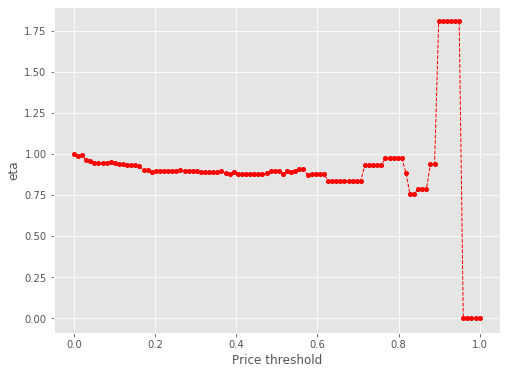

2462 85
Number of cells with price above 10.0th percentile:  85


eta =  1.0
eta =  0.9976179542549592
eta =  0.9699896674242873
eta =  0.9661739231850162
eta =  0.953477848112903
eta =  0.9486119152272624
eta =  0.9507537979701876
eta =  0.9533743079150079
eta =  0.9556412896925626
eta =  0.9428058988381193
eta =  0.9452657615572001
eta =  0.9382578142316148
eta =  0.9399783273233433
eta =  0.940201926229908
eta =  0.940201926229908
eta =  0.9304127793735475
eta =  0.9080922627706807
eta =  0.9080922627706807
eta =  0.9080922627706807
eta =  0.9048102061240811
eta =  0.9048102061240811
eta =  0.9048102061240811
eta =  0.9048102061240811
eta =  0.9019662145325524
eta =  0.90095043650965
eta =  0.9085653089116495
eta =  0.9014440322088955
eta =  0.9014440322088955
eta =  0.9014440322088955
eta =  0.9014440322088955
eta =  0.9014440322088955
eta =  0.8967421909741251
eta =  0.8967421909741251
eta =  0.8967421909741251
eta =  0.8967421909741251
eta =  0.900604390216985
eta =  0.8892299562144231
eta =  0.8759457461003041
eta =  0.884513710457908
eta =  0

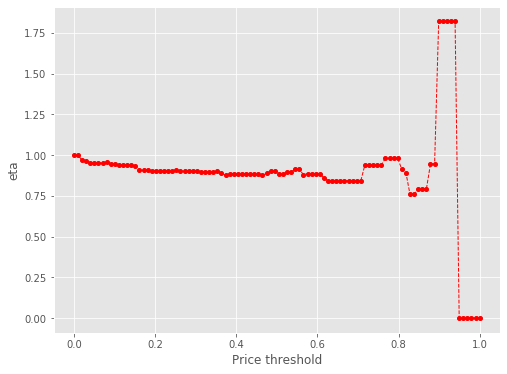

2462 83
Number of cells with price above 11.0th percentile:  83


eta =  1.0
eta =  0.9723057441851021
eta =  0.9684808889657303
eta =  0.9557544990506702
eta =  0.9508769476143847
eta =  0.9530239446023495
eta =  0.9556507116263827
eta =  0.9579231063521249
eta =  0.9450570680057832
eta =  0.9475228042213246
eta =  0.940498123785597
eta =  0.9422227450039605
eta =  0.9424468778051106
eta =  0.9424468778051106
eta =  0.932634357075498
eta =  0.9102605450288451
eta =  0.9102605450288451
eta =  0.9102605450288451
eta =  0.9069706517058539
eta =  0.9069706517058539
eta =  0.9069706517058539
eta =  0.9069706517058539
eta =  0.9041198694205124
eta =  0.9031016659904618
eta =  0.9107347206779012
eta =  0.9015522065278986
eta =  0.9035964402646618
eta =  0.9035964402646618
eta =  0.9035964402646618
eta =  0.9035964402646618
eta =  0.8988833722863678
eta =  0.8988833722863678
eta =  0.8988833722863678
eta =  0.8988833722863678
eta =  0.9027547934314937
eta =  0.9027547934314937
eta =  0.8780372710457859
eta =  0.8866256934183591
eta =  0.9081545203996765
eta

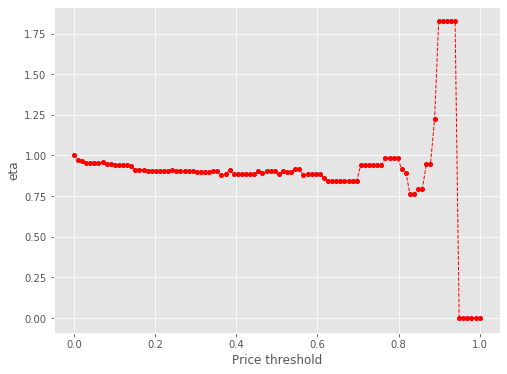

2462 79
Number of cells with price above 12.0th percentile:  79


eta =  1.0
eta =  0.9882050366389329
eta =  0.9729976635265486
eta =  0.9665377959467032
eta =  0.9708673765574923
eta =  0.9708673765574923
eta =  0.973684680025068
eta =  0.9607594989821707
eta =  0.9712909300005503
eta =  0.9606195442081371
eta =  0.9598560230198062
eta =  0.959863946499775
eta =  0.960092275731045
eta =  0.9500960355398818
eta =  0.9440941461955435
eta =  0.9273033194404056
eta =  0.9273033194404056
eta =  0.9164111068065438
eta =  0.9239518295667914
eta =  0.9239518295667914
eta =  0.9239518295667914
eta =  0.9239518295667914
eta =  0.9210476721904929
eta =  0.9200104049753994
eta =  0.9277863730625457
eta =  0.920514442889978
eta =  0.920514442889978
eta =  0.920514442889978
eta =  0.920514442889978
eta =  0.9157131323147933
eta =  0.9157131323147933
eta =  0.9157131323147933
eta =  0.9157131323147933
eta =  0.9157131323147933
eta =  0.9196570379343797
eta =  0.9080419732105048
eta =  0.8944767302941281
eta =  0.9032259533801303
eta =  0.9056287485339918
eta =  0

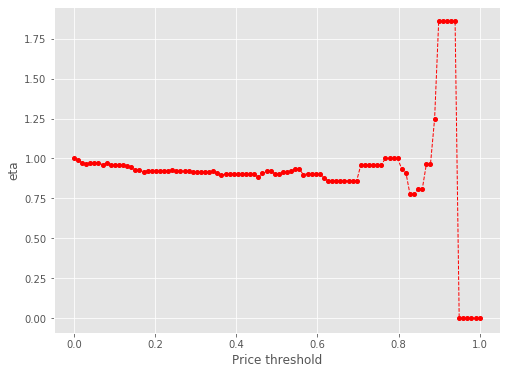

2462 76
Number of cells with price above 13.0th percentile:  76


eta =  1.0
eta =  0.9868594310326031
eta =  0.984040010970286
eta =  0.984040010970286
eta =  0.9867522658572547
eta =  0.9890986154358912
eta =  0.9758138531933633
eta =  0.9783598365407216
eta =  0.9711065386018956
eta =  0.9728872874406312
eta =  0.9731187146207684
eta =  0.9731187146207684
eta =  0.9629868464121023
eta =  0.9398848809509701
eta =  0.9398848809509701
eta =  0.9398848809509701
eta =  0.9288448838323923
eta =  0.9364879183877701
eta =  0.9364879183877701
eta =  0.9364879183877701
eta =  0.9364879183877701
eta =  0.933544357685828
eta =  0.9324930169297518
eta =  0.9269708514523005
eta =  0.933003893581875
eta =  0.933003893581875
eta =  0.933003893581875
eta =  0.933003893581875
eta =  0.9281374392904255
eta =  0.9281374392904255
eta =  0.9281374392904255
eta =  0.9281374392904255
eta =  0.9281374392904255
eta =  0.9321348554389881
eta =  0.9203621986433402
eta =  0.9066129038265981
eta =  0.915480835522953
eta =  0.9179162315684448
eta =  0.9179162315684448
eta =  0.

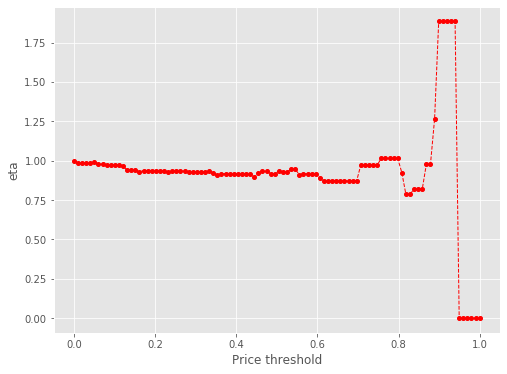

2462 73
Number of cells with price above 14.000000000000002th percentile:  73


eta =  1.0
eta =  0.9876287382506701
eta =  0.9920527951822461
eta =  0.9920527951822461
eta =  0.9949315753816544
eta =  0.9817243523443444
eta =  0.9799483037259195
eta =  0.9815813435996573
eta =  0.980801161519845
eta =  0.9808092578990626
eta =  0.9810425695310864
eta =  0.9708282001306852
eta =  0.9708282001306852
eta =  0.9475381213184203
eta =  0.9475381213184203
eta =  0.9364082283484283
eta =  0.9441134981645009
eta =  0.9441134981645009
eta =  0.9441134981645009
eta =  0.9441134981645009
eta =  0.9411459688063492
eta =  0.9400860672534377
eta =  0.9480317157141516
eta =  0.9384731533287002
eta =  0.9406011038424807
eta =  0.9406011038424807
eta =  0.9406011038424807
eta =  0.9406011038424807
eta =  0.9356950232678721
eta =  0.9356950232678721
eta =  0.9356950232678721
eta =  0.9356950232678721
eta =  0.9356950232678721
eta =  0.9397249893459566
eta =  0.9278564708399581
eta =  0.9229353600376599
eta =  0.9354345736277927
eta =  0.9253905868855232
eta =  0.9253905868855232
et

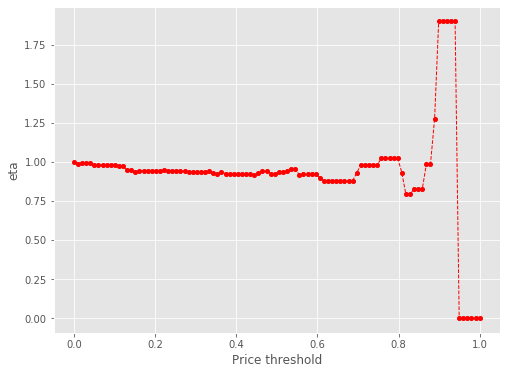

2462 69
Number of cells with price above 15.000000000000002th percentile:  69


eta =  1.0
eta =  1.0051564538570843
eta =  1.0051564538570843
eta =  1.0080732588000507
eta =  0.9967537715598803
eta =  0.9993543889783595
eta =  0.9945466887411486
eta =  0.9937562015246261
eta =  0.9940007982050553
eta =  0.9940007982050553
eta =  0.9836515109748253
eta =  0.9774376470058979
eta =  0.9600538021203409
eta =  0.9600538021203409
eta =  0.9487768985080981
eta =  0.9565839443850394
eta =  0.9565839443850394
eta =  0.9565839443850394
eta =  0.9565839443850394
eta =  0.9535772180284964
eta =  0.9525033166277485
eta =  0.9605539162219959
eta =  0.9508690983191674
eta =  0.953025156144721
eta =  0.953025156144721
eta =  0.953025156144721
eta =  0.953025156144721
eta =  0.948054272965258
eta =  0.948054272965258
eta =  0.948054272965258
eta =  0.948054272965258
eta =  0.948054272965258
eta =  0.9521374693756544
eta =  0.9401121839957215
eta =  0.9351260720598469
eta =  0.9477903831421539
eta =  0.9376137290916076
eta =  0.9376137290916076
eta =  0.9376137290916076
eta =  0.9

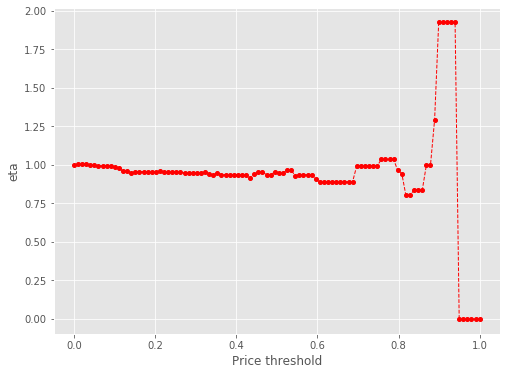

2462 67
Number of cells with price above 16.0th percentile:  67


eta =  1.0
eta =  1.0029018417299853
eta =  0.9916404234734201
eta =  0.9942276997213114
eta =  0.9894446629922905
eta =  0.9886582309761708
eta =  0.9886663922144203
eta =  0.9889015728753255
eta =  0.9786053775014445
eta =  0.9786053775014445
eta =  0.9551287249227012
eta =  0.9551287249227012
eta =  0.9439096718399996
eta =  0.9516766675618927
eta =  0.9516766675618927
eta =  0.9516766675618927
eta =  0.9516766675618927
eta =  0.9486853657152943
eta =  0.9447846820321962
eta =  0.9476169734300665
eta =  0.9459911386634388
eta =  0.9481361359096686
eta =  0.9481361359096686
eta =  0.9481361359096686
eta =  0.9481361359096686
eta =  0.9431907533670919
eta =  0.9431907533670919
eta =  0.9431907533670919
eta =  0.9431907533670919
eta =  0.9431907533670919
eta =  0.9472530029748301
eta =  0.9472530029748301
eta =  0.9213171148728567
eta =  0.9303288741483875
eta =  0.9429282172991083
eta =  0.9328037694964847
eta =  0.9328037694964847
eta =  0.9328037694964847
eta =  0.9328037694964847
e

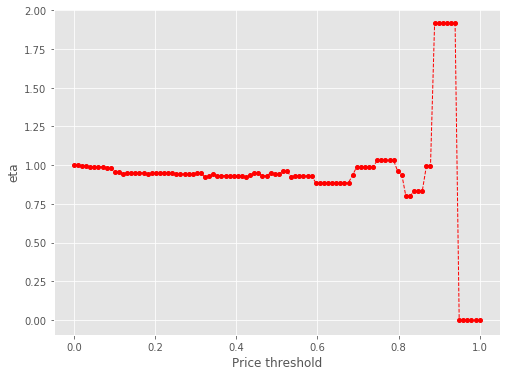

2462 66
Number of cells with price above 17.0th percentile:  66


eta =  1.0
eta =  1.0023778507127095
eta =  0.988914732661507
eta =  0.9914948973446317
eta =  0.9841442195810245
eta =  0.9859407372228858
eta =  0.9861834102558235
eta =  0.9861834102558235
eta =  0.9759155157100087
eta =  0.9697505211035572
eta =  0.9525033926670866
eta =  0.9525033926670866
eta =  0.9413151770423809
eta =  0.9490608238676638
eta =  0.9490608238676638
eta =  0.9490608238676638
eta =  0.9490608238676638
eta =  0.946077744118275
eta =  0.9450122884892851
eta =  0.9529995735868382
eta =  0.9433909226034939
eta =  0.9455300239633246
eta =  0.9455300239633246
eta =  0.9455300239633246
eta =  0.9455300239633246
eta =  0.9405982346380458
eta =  0.9405982346380458
eta =  0.9405982346380458
eta =  0.9405982346380458
eta =  0.9405982346380458
eta =  0.94464931846818
eta =  0.94464931846818
eta =  0.9187847195252858
eta =  0.9277717084618158
eta =  0.9502996328586681
eta =  0.9302398011429874
eta =  0.9302398011429874
eta =  0.9302398011429874
eta =  0.9302398011429874
eta =  

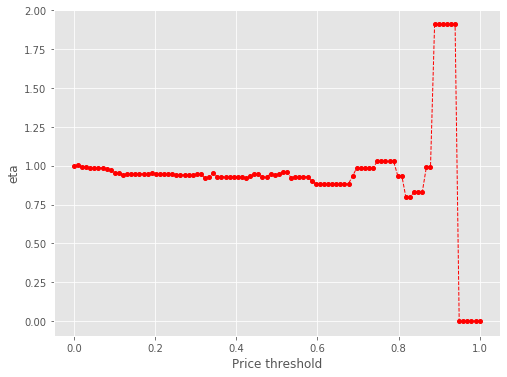

2462 64
Number of cells with price above 18.000000000000004th percentile:  64


eta =  1.0
eta =  0.9942438746666126
eta =  0.9891428632822046
eta =  0.9818096228695391
eta =  0.9836099982931271
eta =  0.9838439761559261
eta =  0.9838439761559261
eta =  0.9736004392117347
eta =  0.9674500692668402
eta =  0.9502438546400829
eta =  0.9502438546400829
eta =  0.9390821798118225
eta =  0.946809452336625
eta =  0.946809452336625
eta =  0.946809452336625
eta =  0.946809452336625
eta =  0.9438334490787041
eta =  0.9427705209341602
eta =  0.9507388585145188
eta =  0.9411530012686584
eta =  0.943287028230956
eta =  0.943287028230956
eta =  0.943287028230956
eta =  0.943287028230956
eta =  0.9383669381453937
eta =  0.9383669381453937
eta =  0.9383669381453937
eta =  0.9383669381453937
eta =  0.9383669381453937
eta =  0.9424084119541514
eta =  0.9424084119541514
eta =  0.9305060024148764
eta =  0.9255708391822032
eta =  0.9381057447808627
eta =  0.9280330770293551
eta =  0.9280330770293551
eta =  0.9280330770293551
eta =  0.9280330770293551
eta =  0.9280330770293551
eta =  0.

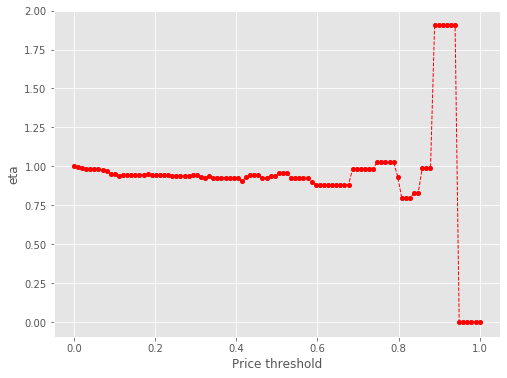

2462 61
Number of cells with price above 19.0th percentile:  61


eta =  1.0
eta =  0.9941691733304403
eta =  0.9892963928233313
eta =  0.9893045593295194
eta =  0.9895398917954875
eta =  0.9895398917954875
eta =  0.9792370504049623
eta =  0.955745244051633
eta =  0.955745244051633
eta =  0.955745244051633
eta =  0.9445189492635429
eta =  0.9522909584472993
eta =  0.9522909584472993
eta =  0.9522909584472993
eta =  0.9522909584472993
eta =  0.9492977257669182
eta =  0.9482286438528855
eta =  0.9562431137263161
eta =  0.9466017596379395
eta =  0.9487481414429197
eta =  0.9487481414429197
eta =  0.9487481414429197
eta =  0.9487481414429197
eta =  0.9437995667411526
eta =  0.9437995667411526
eta =  0.9437995667411526
eta =  0.9437995667411526
eta =  0.9437995667411526
eta =  0.9478644384609938
eta =  0.9478644384609938
eta =  0.935893120515217
eta =  0.9309293854011053
eta =  0.9435368612106623
eta =  0.9334058782514912
eta =  0.9334058782514912
eta =  0.9334058782514912
eta =  0.9334058782514912
eta =  0.9334058782514912
eta =  0.9308389547377279
eta =

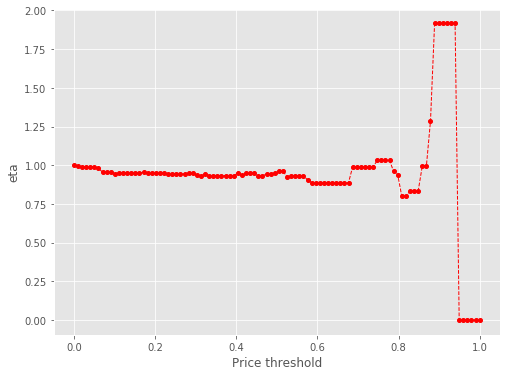

2462 56
Number of cells with price above 20.0th percentile:  56


eta =  1.0
eta =  0.9992051783737543
eta =  0.9994511162298633
eta =  0.9994511162298633
eta =  0.9890450816541213
eta =  0.9890450816541213
eta =  0.9653179815374306
eta =  0.9653179815374306
eta =  0.9653179815374306
eta =  0.9618290978333449
eta =  0.9618290978333449
eta =  0.9618290978333449
eta =  0.9618290978333449
eta =  0.9618290978333449
eta =  0.9588058849559798
eta =  0.9577260951251905
eta =  0.9658208378711922
eta =  0.9560829160496566
eta =  0.9582507959993477
eta =  0.9582507959993477
eta =  0.9582507959993477
eta =  0.9582507959993477
eta =  0.9532526564089832
eta =  0.9532526564089832
eta =  0.9532526564089832
eta =  0.9532526564089832
eta =  0.9532526564089832
eta =  0.9573582418547149
eta =  0.9573582418547149
eta =  0.9311456712360228
eta =  0.9402535674252622
eta =  0.9529873196217901
eta =  0.9427548648102141
eta =  0.9427548648102141
eta =  0.9427548648102141
eta =  0.9427548648102141
eta =  0.9427548648102141
eta =  0.9401622310090114
eta =  0.9401622310090114
e

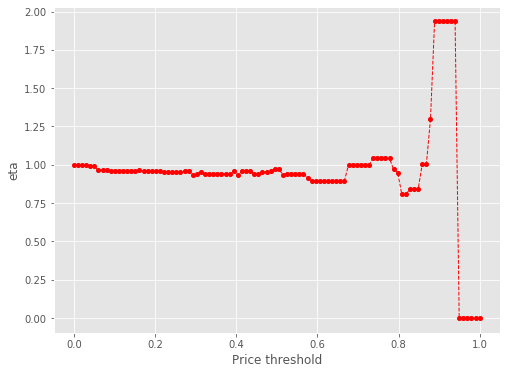

2462 53
Number of cells with price above 21.000000000000004th percentile:  53


eta =  1.0
eta =  1.0002461334883284
eta =  1.0002461334883284
eta =  0.9898318213921099
eta =  0.9898318213921099
eta =  0.9660858474618031
eta =  0.9660858474618031
eta =  0.9660858474618031
eta =  0.9625941885116723
eta =  0.9625941885116723
eta =  0.9625941885116723
eta =  0.9625941885116723
eta =  0.9625941885116723
eta =  0.9595685708079237
eta =  0.9584879220541344
eta =  0.9665891037945816
eta =  0.9568434359054454
eta =  0.9590130403036327
eta =  0.9590130403036327
eta =  0.9590130403036327
eta =  0.9590130403036327
eta =  0.9540109249237871
eta =  0.9540109249237871
eta =  0.9540109249237871
eta =  0.9540109249237871
eta =  0.9540109249237871
eta =  0.9581197761733511
eta =  0.9581197761733511
eta =  0.9460189355833919
eta =  0.9410014957644254
eta =  0.9537453770734199
eta =  0.9435047828160625
eta =  0.9435047828160625
eta =  0.9435047828160625
eta =  0.9435047828160625
eta =  0.9435047828160625
eta =  0.9409100866942687
eta =  0.9409100866942687
eta =  0.9409100866942687
e

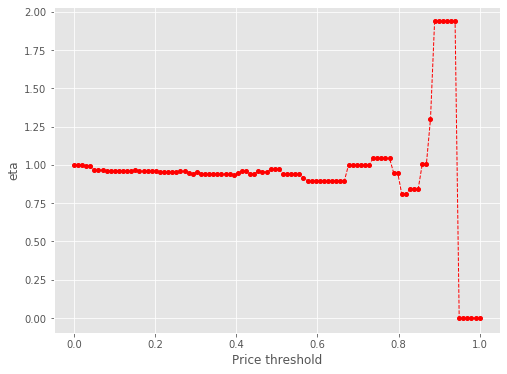

2462 51
Number of cells with price above 22.0th percentile:  51


eta =  1.0
eta =  0.9895882505839849
eta =  0.9658481198948581
eta =  0.9658481198948581
eta =  0.9658481198948581
eta =  0.9545031555521671
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9593324469662853
eta =  0.9440257096700563
eta =  0.958252064130892
eta =  0.9663512523898804
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9578840088408411
eta =  0.9578840088408411
eta =  0.945786145940079
eta =  0.9407699407771875
eta =  0.9407699407771875
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9406785542003276
eta =  0.9406785542003276
eta =  0.9406785542003276
eta =  0.9188866123445357
eta =  0.9436721875828594
eta

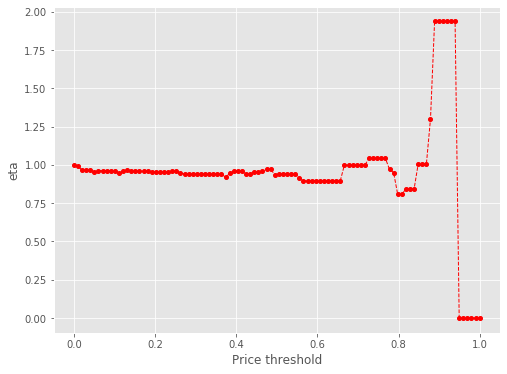

2462 51
Number of cells with price above 23.0th percentile:  51


eta =  1.0
eta =  0.9895882505839849
eta =  0.9658481198948581
eta =  0.9658481198948581
eta =  0.9658481198948581
eta =  0.9545031555521671
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9623573201474461
eta =  0.9593324469662853
eta =  0.9440257096700563
eta =  0.958252064130892
eta =  0.9663512523898804
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9587770531630084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9537761686683084
eta =  0.9578840088408411
eta =  0.9578840088408411
eta =  0.945786145940079
eta =  0.9407699407771875
eta =  0.9407699407771875
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9432726118376663
eta =  0.9406785542003276
eta =  0.9406785542003276
eta =  0.9406785542003276
eta =  0.9188866123445357
eta =  0.9436721875828594
eta

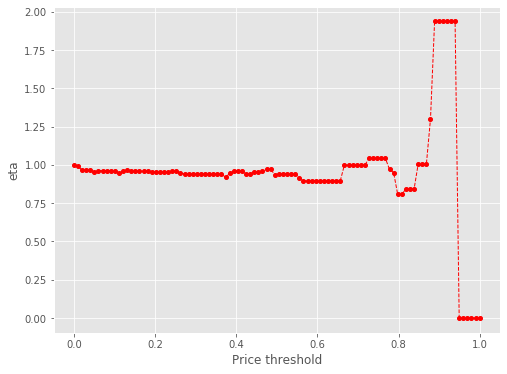

2462 50
Number of cells with price above 24.000000000000004th percentile:  50


eta =  1.0
eta =  0.9760100924044752
eta =  0.9760100924044752
eta =  0.9760100924044752
eta =  0.964545764350867
eta =  0.9724825649248877
eta =  0.9724825649248877
eta =  0.9724825649248877
eta =  0.9724825649248877
eta =  0.9694258661621691
eta =  0.9683341163007942
eta =  0.976518518504649
eta =  0.9666727369501322
eta =  0.9688646288971258
eta =  0.9688646288971258
eta =  0.9688646288971258
eta =  0.9688646288971258
eta =  0.9688646288971258
eta =  0.9638111286239072
eta =  0.9638111286239072
eta =  0.9638111286239072
eta =  0.9638111286239072
eta =  0.9638111286239072
eta =  0.9679621885926453
eta =  0.9679621885926453
eta =  0.9557370405135095
eta =  0.9506680583788374
eta =  0.9506680583788374
eta =  0.9531970607785749
eta =  0.9531970607785749
eta =  0.9531970607785749
eta =  0.9531970607785749
eta =  0.9531970607785749
eta =  0.9531970607785749
eta =  0.9505757102968895
eta =  0.9505757102968895
eta =  0.9285544890031525
eta =  0.9536008405778573
eta =  0.9679821041070588
eta

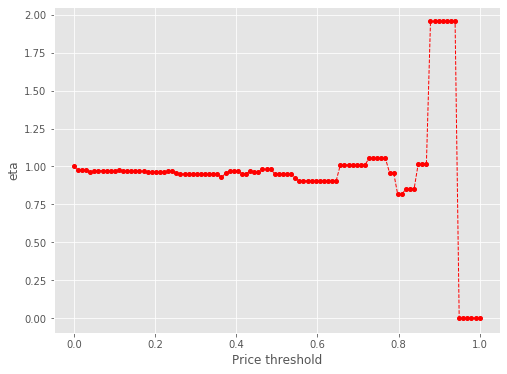

2462 48
Number of cells with price above 25.0th percentile:  48


eta =  1.0
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9932539363132143
eta =  0.9921353517105848
eta =  0.9921353517105848
eta =  0.9862599880470433
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9917542821795999
eta =  0.9792286452274059
eta =  0.964599944313704
eta =  0.9740350696956364
eta =  0.9872263211175224
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9739404517376186
eta =  0.9739404517376186
eta =  0.9739404517376186
eta =  0.9513779583114635
eta =  0.9770399384176337
eta =  0.9917746872087779
eta =  0.9917746872087779
eta =  0.9917746872087779
et

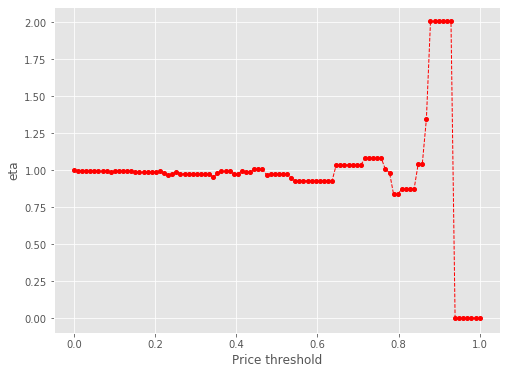

2462 48
Number of cells with price above 26.0th percentile:  48


eta =  1.0
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9963857674146614
eta =  0.9932539363132143
eta =  0.9921353517105848
eta =  0.9921353517105848
eta =  0.9862599880470433
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9926789040779834
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9875011909451521
eta =  0.9917542821795999
eta =  0.9792286452274059
eta =  0.964599944313704
eta =  0.9740350696956364
eta =  0.9872263211175224
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9766262338848376
eta =  0.9739404517376186
eta =  0.9739404517376186
eta =  0.9739404517376186
eta =  0.9513779583114635
eta =  0.9770399384176337
eta =  0.9917746872087779
eta =  0.9917746872087779
eta =  0.9917746872087779
et

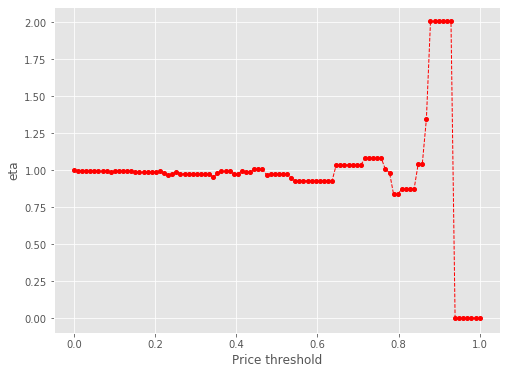

2462 47
Number of cells with price above 27.0th percentile:  47


eta =  1.0
eta =  1.0082285370662138
eta =  1.0082285370662138
eta =  1.0082285370662138
eta =  1.0082285370662138
eta =  1.0050594818739227
eta =  1.0009270062785678
eta =  1.003927602079593
eta =  1.0124128419783582
eta =  1.0044776149622774
eta =  1.0044776149622774
eta =  1.0044776149622774
eta =  1.0044776149622774
eta =  1.0044776149622774
eta =  0.9992383609424128
eta =  0.9992383609424128
eta =  0.9992383609424128
eta =  0.9992383609424128
eta =  0.9992383609424128
eta =  0.9992383609424128
eta =  1.0035420032600293
eta =  1.0035420032600293
eta =  0.9908674900010724
eta =  0.9856121850461194
eta =  0.9989602240869319
eta =  0.9882341471066126
eta =  0.9882341471066126
eta =  0.9882341471066126
eta =  0.9882341471066126
eta =  0.9882341471066126
eta =  0.9882341471066126
eta =  0.9855164424848422
eta =  0.9855164424848422
eta =  0.9855164424848422
eta =  0.9764122688192859
eta =  0.9886527688187242
eta =  1.0035626508178224
eta =  1.0035626508178224
eta =  0.9879427064937282
et

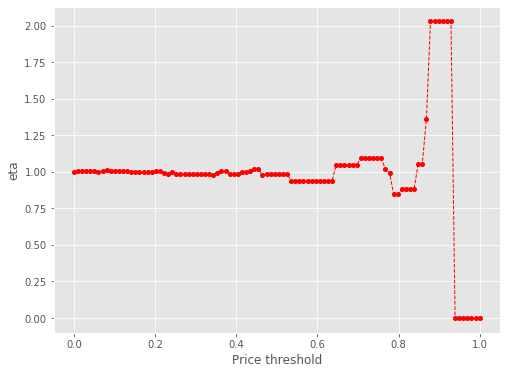

2462 46
Number of cells with price above 28.000000000000004th percentile:  46


eta =  1.0
eta =  0.9968568086740407
eta =  0.9957341665817795
eta =  1.0041501552061995
eta =  0.9940257767241265
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.9953517147810341
eta =  0.9953517147810341
eta =  0.9827806430517636
eta =  0.9775682286419859
eta =  0.9775682286419859
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.9548289321514694
eta =  0.980583997052442
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9798797298165015
eta =  0.9775387425396378
eta =  0.9775387425396378
eta =  0.9907841114466449
eta =  0.99

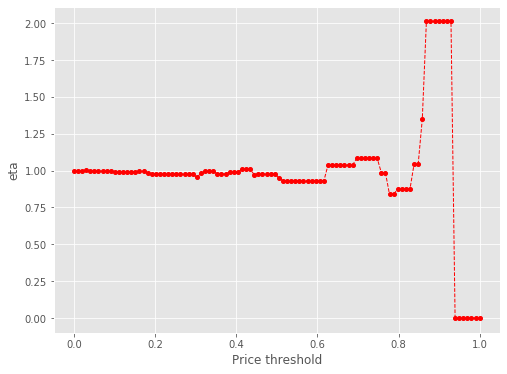

2462 46
Number of cells with price above 29.000000000000004th percentile:  46


eta =  1.0
eta =  0.9968568086740407
eta =  0.9957341665817795
eta =  1.0041501552061995
eta =  0.9940257767241265
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.9953517147810341
eta =  0.9953517147810341
eta =  0.9827806430517636
eta =  0.9775682286419859
eta =  0.9775682286419859
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.9548289321514694
eta =  0.980583997052442
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9798797298165015
eta =  0.9775387425396378
eta =  0.9775387425396378
eta =  0.9907841114466449
eta =  0.99

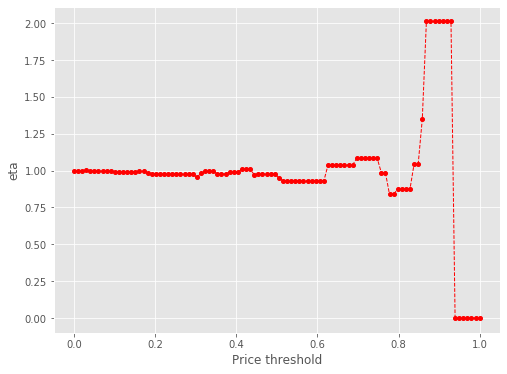

2462 46
Number of cells with price above 30.0th percentile:  46


eta =  1.0
eta =  0.9968568086740407
eta =  0.9957341665817795
eta =  1.0041501552061995
eta =  0.9940257767241265
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.9962796905998604
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.991083196127377
eta =  0.9953517147810341
eta =  0.9953517147810341
eta =  0.9827806430517636
eta =  0.9775682286419859
eta =  0.9775682286419859
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.9801687918715516
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.977473267472214
eta =  0.9548289321514694
eta =  0.980583997052442
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9953721938262445
eta =  0.9798797298165015
eta =  0.9775387425396378
eta =  0.9775387425396378
eta =  0.9907841114466449
eta =  0.99

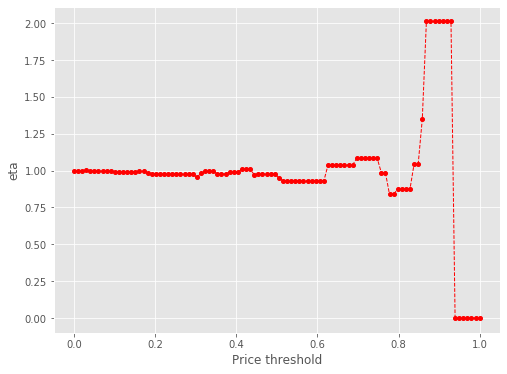

2462 45
Number of cells with price above 31.0th percentile:  45


eta =  1.0
eta =  1.0182281291926936
eta =  1.01708141910614
eta =  1.025677835640375
eta =  1.015336403579784
eta =  1.0176386384535194
eta =  1.0176386384535194
eta =  1.0176386384535194
eta =  1.0176386384535194
eta =  1.0176386384535194
eta =  1.0123307378613422
eta =  1.0123307378613422
eta =  1.0123307378613422
eta =  1.0123307378613422
eta =  1.0123307378613422
eta =  1.0123307378613422
eta =  1.0166907680334976
eta =  1.0166907680334976
eta =  1.0038501887873486
eta =  0.9985260269550141
eta =  0.9985260269550141
eta =  1.001182342896328
eta =  1.001182342896328
eta =  1.001182342896328
eta =  1.001182342896328
eta =  1.001182342896328
eta =  1.001182342896328
eta =  0.998429029940597
eta =  0.998429029940597
eta =  0.998429029940597
eta =  0.9752992293615921
eta =  1.0016064495392183
eta =  1.0167116861229473
eta =  1.0167116861229473
eta =  1.0167116861229473
eta =  1.0008870837247266
eta =  0.9984959087087727
eta =  0.9984959087087727
eta =  1.0120252411919286
eta =  1.01202

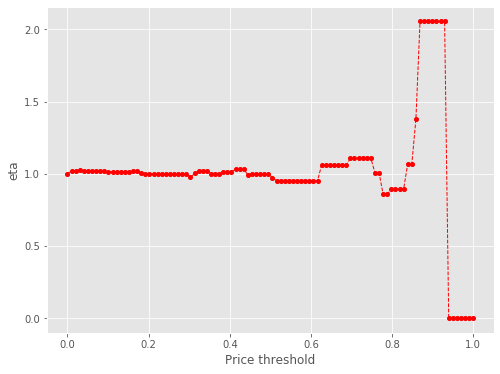

2462 41
Number of cells with price above 32.0th percentile:  41


eta =  1.0
eta =  1.002997816806024
eta =  1.0114751981190861
eta =  1.0035473202955234
eta =  1.0035473202955234
eta =  1.0035473202955234
eta =  1.0035473202955234
eta =  1.0035473202955234
eta =  1.0035473202955234
eta =  0.9983129185988963
eta =  0.9983129185988963
eta =  0.9983129185988963
eta =  0.9983129185988963
eta =  0.9983129185988963
eta =  0.9983129185988963
eta =  1.0026125751079331
eta =  1.0026125751079331
eta =  0.9751609360252733
eta =  0.9846993625545295
eta =  0.9846993625545295
eta =  0.9873188962908024
eta =  0.9873188962908024
eta =  0.9873188962908024
eta =  0.9873188962908024
eta =  0.9873188962908024
eta =  0.9873188962908024
eta =  0.9846037086650085
eta =  0.9846037086650085
eta =  0.9846037086650085
eta =  0.9617941881604563
eta =  0.9877371302973639
eta =  1.0026332035430374
eta =  1.0026332035430374
eta =  1.0026332035430374
eta =  0.9870277255949811
eta =  0.9846696613578911
eta =  0.9846696613578911
eta =  0.9980116521646587
eta =  0.9980116521646587
et

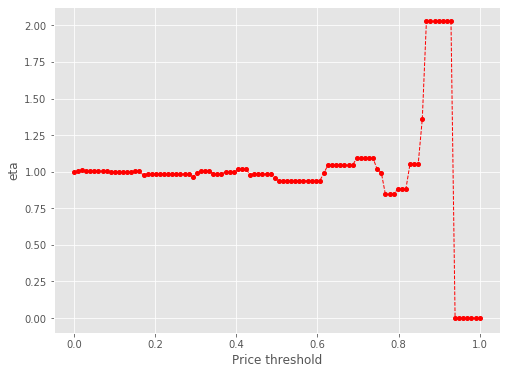

2462 39
Number of cells with price above 33.0th percentile:  39


eta =  1.0
eta =  0.9921620640443729
eta =  0.9921620640443729
eta =  0.9921620640443729
eta =  0.9921620640443729
eta =  0.9921620640443729
eta =  0.9921620640443729
eta =  0.9869870466970756
eta =  0.9869870466970756
eta =  0.9869870466970756
eta =  0.9869870466970756
eta =  0.9869870466970756
eta =  0.9869870466970756
eta =  0.9912379235520222
eta =  0.9912379235520222
eta =  0.9787188080949428
eta =  0.9735279366074935
eta =  0.9735279366074935
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9761177517024598
eta =  0.9734333679124836
eta =  0.9734333679124836
eta =  0.9734333679124836
eta =  0.9644408173559677
eta =  0.9765312408392565
eta =  0.9912583179572855
eta =  0.9912583179572855
eta =  0.9912583179572855
eta =  0.975829884341636
eta =  0.9734985723712832
eta =  0.9734985723712832
eta =  0.9866891981341077
eta =  0.9866891981341077
eta =  0.9928641398712557
et

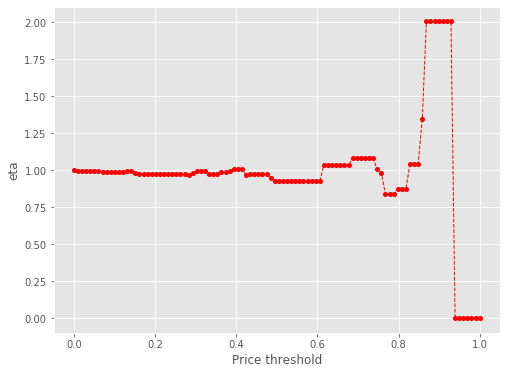

2462 37
Number of cells with price above 34.0th percentile:  37


eta =  1.0
eta =  1.0022674601891732
eta =  1.0022674601891732
eta =  1.0022674601891732
eta =  1.0022674601891732
eta =  1.0022674601891732
eta =  0.997039734113891
eta =  0.997039734113891
eta =  0.997039734113891
eta =  0.997039734113891
eta =  0.997039734113891
eta =  0.997039734113891
eta =  1.001333907115847
eta =  1.001333907115847
eta =  0.988687281622191
eta =  0.973917278098986
eta =  0.9834435399287356
eta =  0.9967622092436744
eta =  0.9860597328791196
eta =  0.9860597328791196
eta =  0.9860597328791196
eta =  0.9860597328791196
eta =  0.9860597328791196
eta =  0.9860597328791196
eta =  0.983348008030071
eta =  0.983348008030071
eta =  0.983348008030071
eta =  0.9605675773300036
eta =  0.9864774334967624
eta =  1.0013545092427636
eta =  1.0013545092427636
eta =  1.0013545092427636
eta =  0.9857689335237924
eta =  0.9834138766111048
eta =  0.9834138766111048
eta =  0.9967388518956071
eta =  0.9967388518956071
eta =  0.9967388518956071
eta =  1.0154144782889443
eta =  1.01541

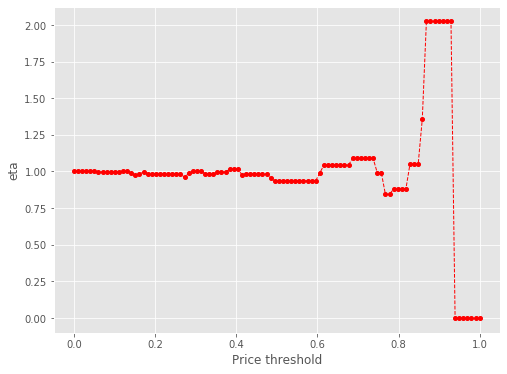

2462 36
Number of cells with price above 35.0th percentile:  36


eta =  1.0
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9990685589322136
eta =  0.9990685589322136
eta =  0.9864505442844378
eta =  0.9717139553898755
eta =  0.981218665667461
eta =  0.9945072037513223
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9720597594959391
eta =  0.9842456955657021
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9811890694580568
eta =  0.9811890694580568
eta =  1.0017776454683291
eta =  0.9944838992452947
eta =  0.9944838992452947
eta =  1.0007076221237696
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  0.9760523988334596
et

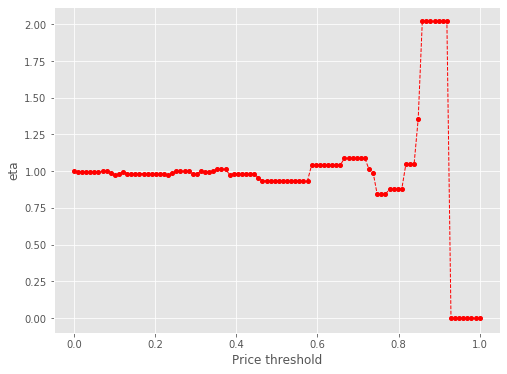

2462 36
Number of cells with price above 36.00000000000001th percentile:  36


eta =  1.0
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9990685589322136
eta =  0.9990685589322136
eta =  0.9864505442844378
eta =  0.9717139553898755
eta =  0.981218665667461
eta =  0.9945072037513223
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9720597594959391
eta =  0.9842456955657021
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9811890694580568
eta =  0.9811890694580568
eta =  1.0017776454683291
eta =  0.9944838992452947
eta =  0.9944838992452947
eta =  1.0007076221237696
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  0.9760523988334596
et

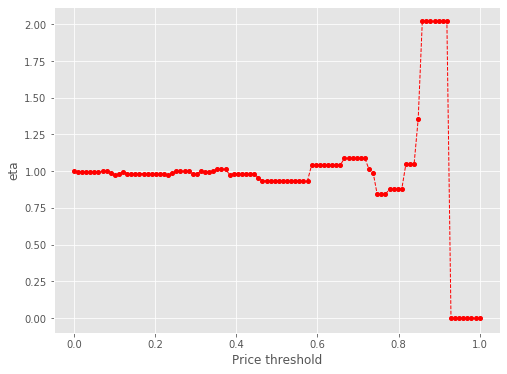

2462 36
Number of cells with price above 37.0th percentile:  36


eta =  1.0
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9947841007685758
eta =  0.9990685589322136
eta =  0.9990685589322136
eta =  0.9864505442844378
eta =  0.9717139553898755
eta =  0.981218665667461
eta =  0.9945072037513223
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9838289399248835
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9811233498935193
eta =  0.9720597594959391
eta =  0.9842456955657021
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9990891144503112
eta =  0.9811890694580568
eta =  0.9811890694580568
eta =  1.0017776454683291
eta =  0.9944838992452947
eta =  0.9944838992452947
eta =  1.0007076221237696
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  1.0131172752004636
eta =  0.9760523988334596
et

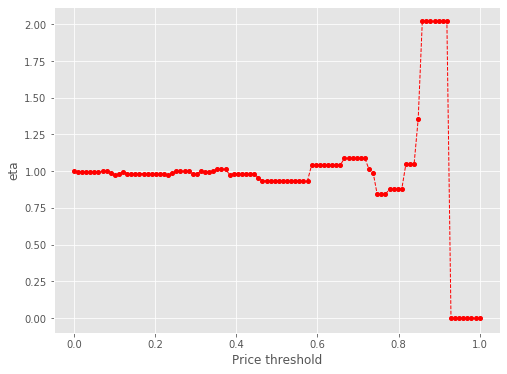

2462 35
Number of cells with price above 38.0th percentile:  35


eta =  1.0
eta =  1.0043069226381156
eta =  1.0043069226381156
eta =  0.9916227486168109
eta =  0.9863634379654498
eta =  0.9863634379654498
eta =  0.999721651143158
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  1.0072841305473514
eta =  0.9771565093822069
eta =  0.9894063393305826
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  0.9886957357821697
eta =  0.9863336865757952
eta =  0.9863336865757952
eta =  1.00703021358539
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  0.98117008311588
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta = 

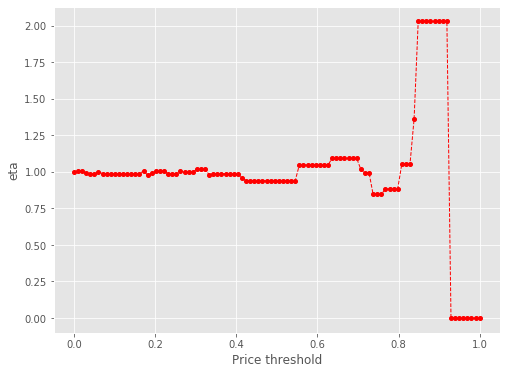

2462 35
Number of cells with price above 39.0th percentile:  35


eta =  1.0
eta =  1.0043069226381156
eta =  1.0043069226381156
eta =  0.9916227486168109
eta =  0.9863634379654498
eta =  0.9863634379654498
eta =  0.999721651143158
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  1.0072841305473514
eta =  0.9771565093822069
eta =  0.9894063393305826
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  0.9886957357821697
eta =  0.9863336865757952
eta =  0.9863336865757952
eta =  1.00703021358539
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  0.98117008311588
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta = 

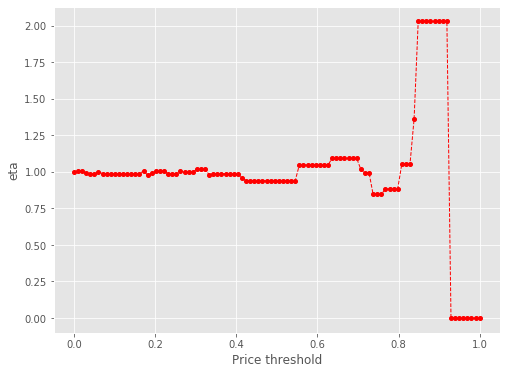

2462 35
Number of cells with price above 40.0th percentile:  35


eta =  1.0
eta =  1.0043069226381156
eta =  1.0043069226381156
eta =  0.9916227486168109
eta =  0.9863634379654498
eta =  0.9863634379654498
eta =  0.999721651143158
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  1.0072841305473514
eta =  0.9771565093822069
eta =  0.9894063393305826
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  0.9886957357821697
eta =  0.9863336865757952
eta =  0.9863336865757952
eta =  1.00703021358539
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  0.98117008311588
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta = 

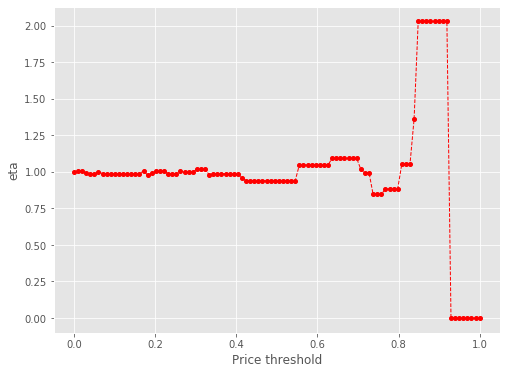

2462 35
Number of cells with price above 41.0th percentile:  35


eta =  1.0
eta =  1.0043069226381156
eta =  1.0043069226381156
eta =  0.9916227486168109
eta =  0.9863634379654498
eta =  0.9863634379654498
eta =  0.999721651143158
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9889873985367998
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  0.9862676224273165
eta =  1.0072841305473514
eta =  0.9771565093822069
eta =  0.9894063393305826
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  1.0043275859338818
eta =  0.9886957357821697
eta =  0.9863336865757952
eta =  0.9863336865757952
eta =  1.00703021358539
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  0.9996982244458378
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  1.0184292998025637
eta =  0.98117008311588
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta =  0.9875257165044038
eta = 

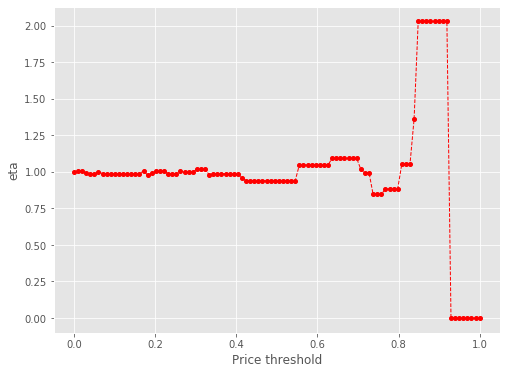

2462 34
Number of cells with price above 42.00000000000001th percentile:  34


eta =  1.0
eta =  0.9873702214578131
eta =  0.9821334651109127
eta =  0.9821334651109127
eta =  0.9954343922245273
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.972966020004532
eta =  0.985163317137761
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  0.984455760978986
eta =  0.9821038413086826
eta =  0.9821038413086826
eta =  0.9954110659914882
eta =  0.9954110659914882
eta =  0.9954110659914882
eta =  1.0016405913056736
eta =  1.0140618140193152
eta =  1.0140618140193152
eta =  1.0140618140193152
eta =  0.9769623817174737
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.9

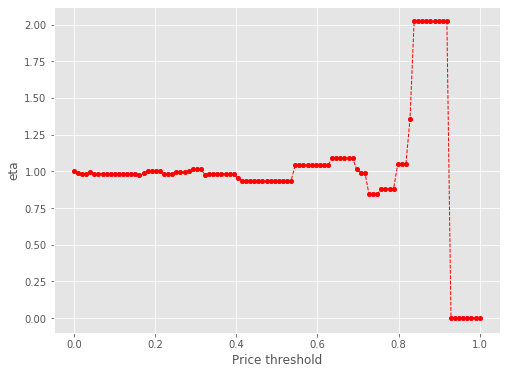

2462 34
Number of cells with price above 43.0th percentile:  34


eta =  1.0
eta =  0.9873702214578131
eta =  0.9821334651109127
eta =  0.9821334651109127
eta =  0.9954343922245273
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9847461729517163
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.9820380604731734
eta =  0.972966020004532
eta =  0.985163317137761
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  1.0000205746822017
eta =  0.984455760978986
eta =  0.9821038413086826
eta =  0.9821038413086826
eta =  0.9954110659914882
eta =  0.9954110659914882
eta =  0.9954110659914882
eta =  1.0016405913056736
eta =  1.0140618140193152
eta =  1.0140618140193152
eta =  1.0140618140193152
eta =  0.9769623817174737
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.983290759273439
eta =  0.9

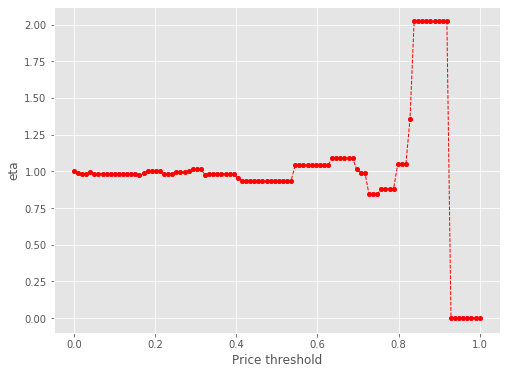

2462 32
Number of cells with price above 44.0th percentile:  32


eta =  1.0
eta =  1.009781387027391
eta =  1.0234567469521436
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0124676448946823
eta =  1.0096832966650855
eta =  1.0096832966650855
eta =  1.0096832966650855
eta =  1.0096832966650855
eta =  0.9862927775600819
eta =  1.012896532056904
eta =  1.012896532056904
eta =  1.028172034484626
eta =  1.028172034484626
eta =  1.028172034484626
eta =  1.0121690575691809
eta =  1.0097509292890414
eta =  1.0097509292890414
eta =  1.0309388271226292
eta =  1.0234327640651033
eta =  1.0234327640651033
eta =  1.0234327640651033
eta =  1.0426085470738928
eta =  1.0426085470738928
eta =  1.0426085470738928
eta =  1.0426085470738928
eta =  1.0044647330827345
eta =  1.010971260039714
eta =  1.010971260039714
eta =  1.010971260039714
eta =  1.010971260039714
eta =  1.010971260039714
eta =  1.010971260039714
eta =  1.010971260039714
eta =  0.98209

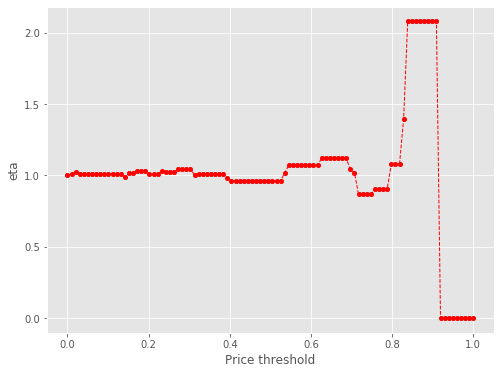

2462 31
Number of cells with price above 45.0th percentile:  31


eta =  1.0
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  1.002660237059032
eta =  0.9999028598035518
eta =  0.9999028598035518
eta =  0.9999028598035518
eta =  1.021209923012814
eta =  0.9906657848123063
eta =  1.003084969746455
eta =  1.018212503907775
eta =  1.018212503907775
eta =  1.018212503907775
eta =  1.018212503907775
eta =  1.0023645420409446
eta =  0.9999698372947441
eta =  0.9999698372947441
eta =  1.0209524956263272
eta =  1.0135191410864675
eta =  1.0135191410864675
eta =  1.0198619911526567
eta =  1.0325091752217168
eta =  1.0325091752217168
eta =  1.0325091752217168
eta =  0.9947348465589094
eta =  0.9947348465589094
eta =  1.001178347142866
eta =  1.001178347142866
eta =  1.001178347142866
eta =  1.001178347142866
eta =  1.001178347142866
eta =  1.001178347142866
eta =  1.001178347142866
eta =  0.9725828730028755
eta =  0.9528519405656

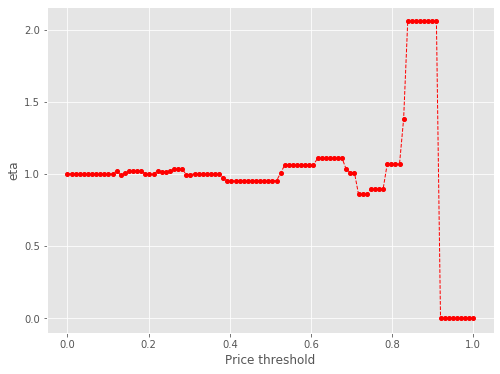

2462 28
Number of cells with price above 46.0th percentile:  28


eta =  1.0
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  1.018500470317035
eta =  0.9880373711817798
eta =  1.000423605795587
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  0.9997050895137172
eta =  0.9973167383477982
eta =  0.9973167383477982
eta =  1.0182437259314774
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  0.9920956369793129
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9700024365737505
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta = 

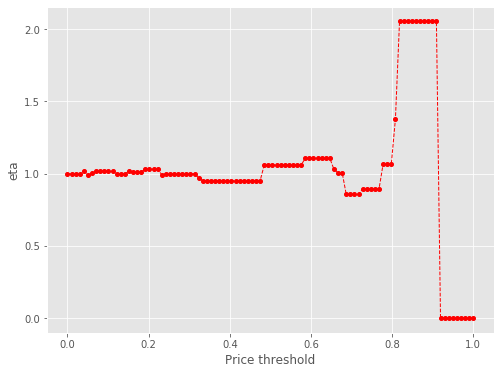

2462 28
Number of cells with price above 47.0th percentile:  28


eta =  1.0
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  1.018500470317035
eta =  0.9880373711817798
eta =  1.000423605795587
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  0.9997050895137172
eta =  0.9973167383477982
eta =  0.9973167383477982
eta =  1.0182437259314774
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  0.9920956369793129
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9700024365737505
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta = 

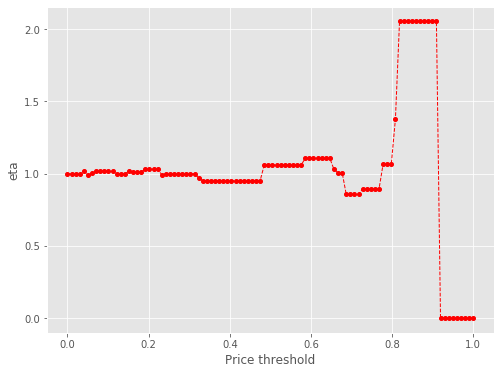

2462 28
Number of cells with price above 48.00000000000001th percentile:  28


eta =  1.0
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  1.018500470317035
eta =  0.9880373711817798
eta =  1.000423605795587
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  0.9997050895137172
eta =  0.9973167383477982
eta =  0.9973167383477982
eta =  1.0182437259314774
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  0.9920956369793129
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9700024365737505
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta = 

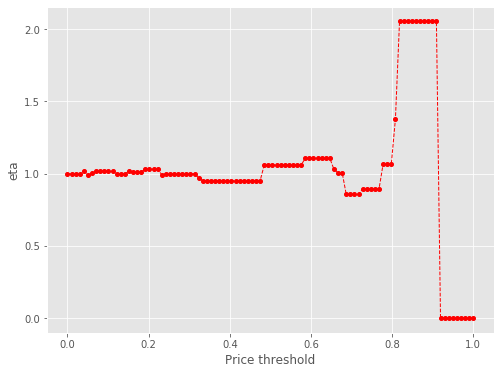

2462 28
Number of cells with price above 49.0th percentile:  28


eta =  1.0
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  0.9972499385598773
eta =  1.018500470317035
eta =  0.9880373711817798
eta =  1.000423605795587
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  1.0155110039013417
eta =  0.9997050895137172
eta =  0.9973167383477982
eta =  0.9973167383477982
eta =  1.0182437259314774
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.010830093411589
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  1.0297697435875552
eta =  0.9920956369793129
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9985220418030011
eta =  0.9700024365737505
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta =  0.9503238538315741
eta = 

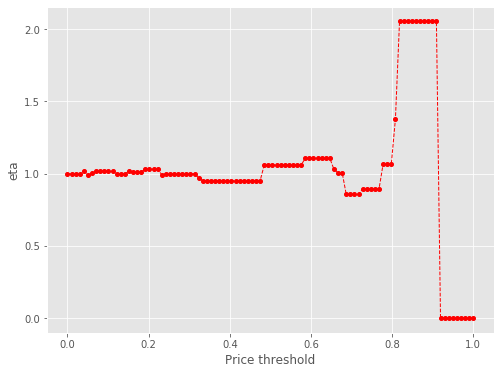

2462 27
Number of cells with price above 50.0th percentile:  27


eta =  1.0
eta =  0.9907620276303037
eta =  1.0031824190837184
eta =  1.0031824190837184
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.0024619213889203
eta =  1.000066983998031
eta =  1.000066983998031
eta =  1.0210516807871828
eta =  1.013617604099653
eta =  1.013617604099653
eta =  1.013617604099653
eta =  1.0199610703714022
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  0.9948314846847646
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  0.9726773590726165
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9

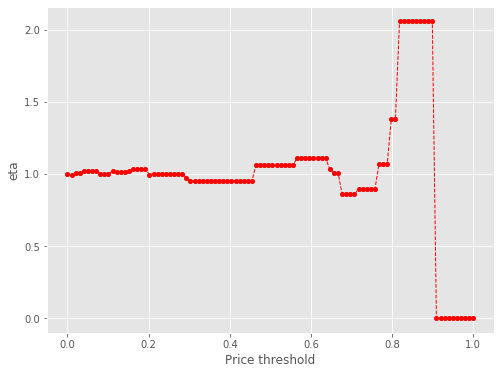

2462 27
Number of cells with price above 51.0th percentile:  27


eta =  1.0
eta =  0.9907620276303037
eta =  1.0031824190837184
eta =  1.0031824190837184
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.018311422879439
eta =  1.0024619213889203
eta =  1.000066983998031
eta =  1.000066983998031
eta =  1.0210516807871828
eta =  1.013617604099653
eta =  1.013617604099653
eta =  1.013617604099653
eta =  1.0199610703714022
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  1.0326094831097603
eta =  0.9948314846847646
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  1.0012756112524417
eta =  0.9726773590726165
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9529445097825037
eta =  0.9

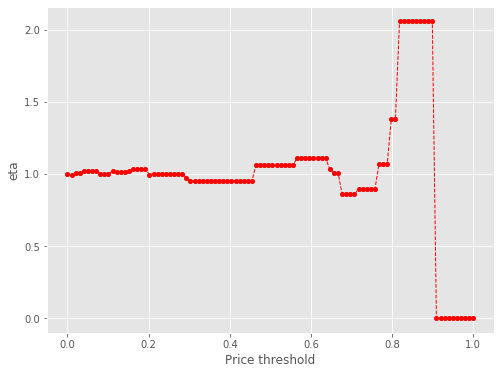

2462 25
Number of cells with price above 52.0th percentile:  25


eta =  1.0
eta =  1.0142585376555806
eta =  1.0269734860703688
eta =  1.0424612831781512
eta =  1.0424612831781512
eta =  1.0424612831781512
eta =  1.0424612831781512
eta =  1.0262359013447429
eta =  1.02378416659097
eta =  1.02378416659097
eta =  1.02378416659097
eta =  1.0376561476977446
eta =  1.0376561476977446
eta =  1.0376561476977446
eta =  1.0376561476977446
eta =  1.0570984304002777
eta =  1.0570984304002777
eta =  1.0570984304002777
eta =  1.0570984304002777
eta =  1.018424504301458
eta =  1.018424504301458
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  1.0250214571586769
eta =  0.9957449804402551
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.9755441549073692
eta =  0.

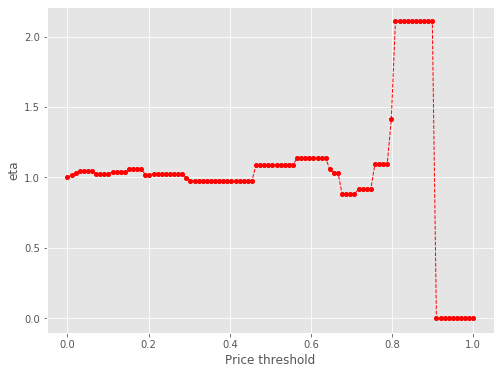

2462 23
Number of cells with price above 53.0th percentile:  23


eta =  1.0
eta =  1.015081009702641
eta =  1.015081009702641
eta =  1.015081009702641
eta =  1.015081009702641
eta =  0.9992817879569139
eta =  0.996894448082002
eta =  0.996894448082002
eta =  0.996894448082002
eta =  1.010402081234105
eta =  1.010402081234105
eta =  1.010402081234105
eta =  1.010402081234105
eta =  1.0293337118616173
eta =  1.0293337118616173
eta =  1.0293337118616173
eta =  1.0293337118616173
eta =  0.9916755574658283
eta =  0.9916755574658283
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9980992411798661
eta =  0.9695917119052342
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.9499214615950898
eta =  0.949

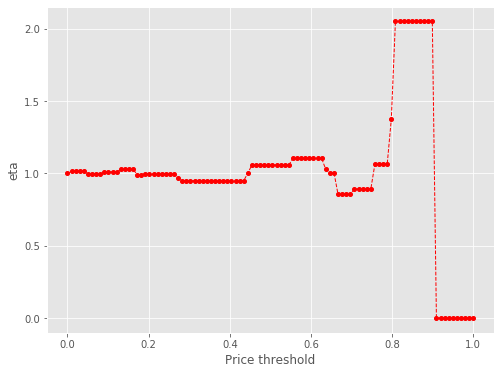

2462 22
Number of cells with price above 54.0th percentile:  22


eta =  1.0
eta =  0.9820836352499919
eta =  0.9820836352499919
eta =  0.9820836352499919
eta =  1.0026909821948136
eta =  0.9953905861465117
eta =  0.9953905861465117
eta =  0.9953905861465117
eta =  1.0016199832928305
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  0.9769422814405037
eta =  0.9769422814405037
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9551865345104499
eta =  0.9551865345104499
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
e

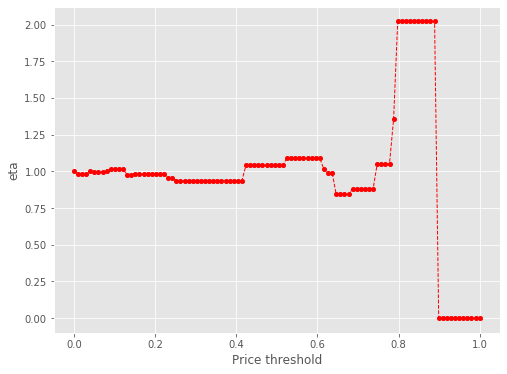

2462 22
Number of cells with price above 55.00000000000001th percentile:  22


eta =  1.0
eta =  0.9820836352499919
eta =  0.9820836352499919
eta =  0.9820836352499919
eta =  1.0026909821948136
eta =  0.9953905861465117
eta =  0.9953905861465117
eta =  0.9953905861465117
eta =  1.0016199832928305
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  1.0140409504490202
eta =  0.9769422814405037
eta =  0.9769422814405037
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9832705287947908
eta =  0.9551865345104499
eta =  0.9551865345104499
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
eta =  0.9358085241623826
e

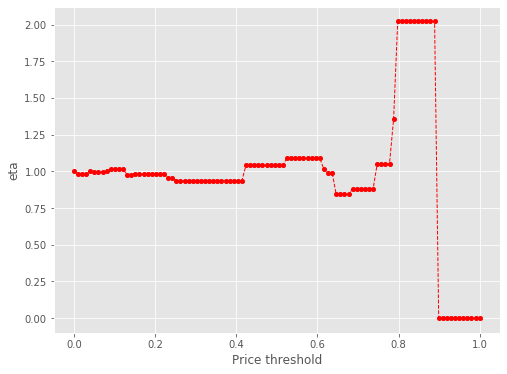

2462 20
Number of cells with price above 56.00000000000001th percentile:  20


eta =  1.0
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0198927538771845
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  0.9947648513579198
eta =  0.9947648513579198
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  0.9726122096182825
eta =  0.9726122096182825
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  1.006297708

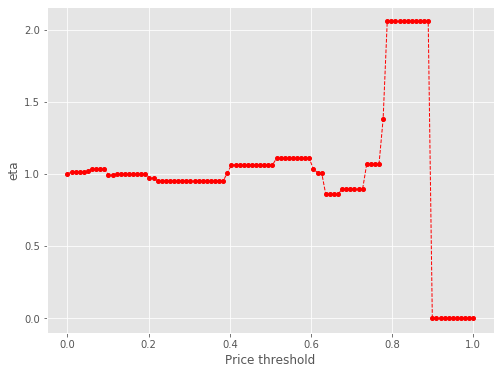

2462 20
Number of cells with price above 57.00000000000001th percentile:  20


eta =  1.0
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0135497124877073
eta =  1.0198927538771845
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  1.0325403194310367
eta =  0.9947648513579198
eta =  0.9947648513579198
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  1.0012085463011478
eta =  0.9726122096182825
eta =  0.9726122096182825
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  0.952880682024775
eta =  1.006297708

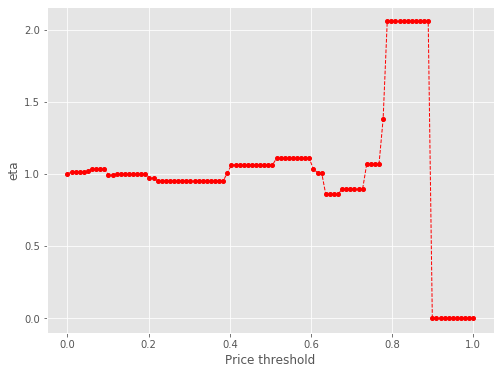

2462 18
Number of cells with price above 58.00000000000001th percentile:  18


eta =  1.0
eta =  1.0187367296436973
eta =  1.0187367296436973
eta =  1.0187367296436973
eta =  1.0187367296436973
eta =  1.0187367296436973
eta =  0.9814662656420857
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9878238175843699
eta =  0.9596097730924852
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  0.9401420278498
eta =  1.047785001809099
eta =  1.047785001809099
eta =  1.047785001809099
eta =  1.047785001809099
eta =  1.0

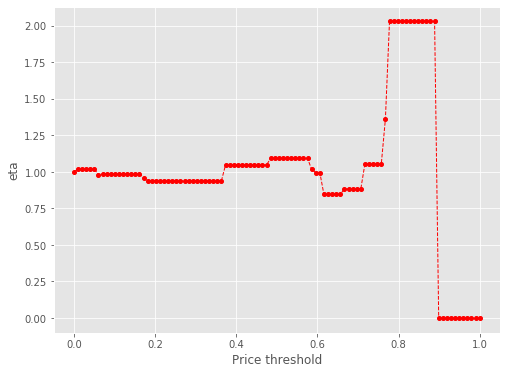

2462 17
Number of cells with price above 59.0th percentile:  17


eta =  1.0
eta =  1.0124008779411087
eta =  1.0124008779411087
eta =  1.0124008779411087
eta =  1.0124008779411087
eta =  0.9753622109542994
eta =  0.9753622109542994
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9816802232342492
eta =  0.9536416509685336
eta =  0.9536416509685336
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  0.9342949819011274
eta =  1.0412684895498612
eta =  1.0412684895498612
eta =  1.0412684895498612
e

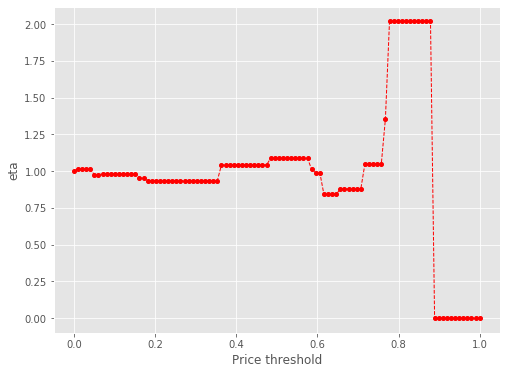

2462 16
Number of cells with price above 60.0th percentile:  16


eta =  1.0
eta =  0.9634150188983106
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.941960513613864
eta =  0.941960513613864
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta

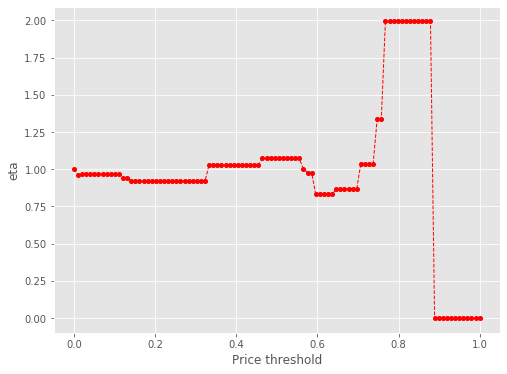

2462 16
Number of cells with price above 61.0th percentile:  16


eta =  1.0
eta =  0.9634150188983106
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.9696556419732318
eta =  0.941960513613864
eta =  0.941960513613864
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  0.9228508215057823
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta =  1.0285140128162076
eta

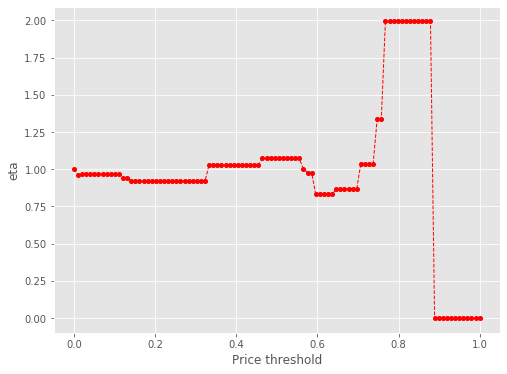

2462 14
Number of cells with price above 62.0th percentile:  14


eta =  1.0
eta =  0.9714381815971197
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  1.0050830190410336
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.1065946728669647
e

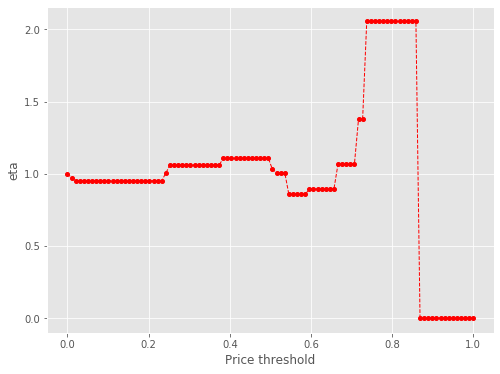

2462 14
Number of cells with price above 63.0th percentile:  14


eta =  1.0
eta =  0.9714381815971197
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  1.0050830190410336
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.1065946728669647
e

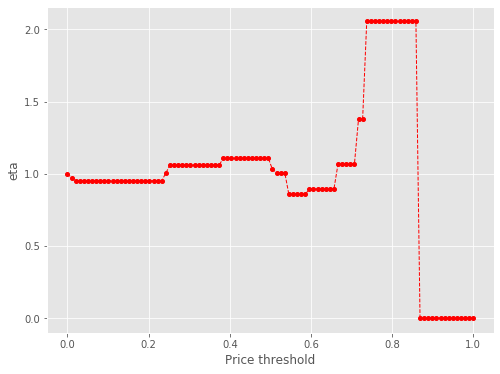

2462 14
Number of cells with price above 64.0th percentile:  14


eta =  1.0
eta =  0.9714381815971197
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  1.0050830190410336
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.1065946728669647
e

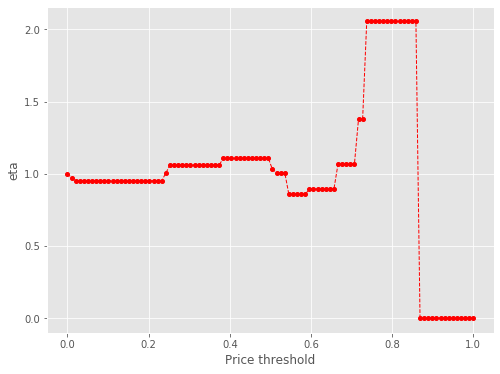

2462 14
Number of cells with price above 65.0th percentile:  14


eta =  1.0
eta =  0.9714381815971197
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  0.9517304716835324
eta =  1.0050830190410336
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.0607002819301912
eta =  1.1065946728669647
e

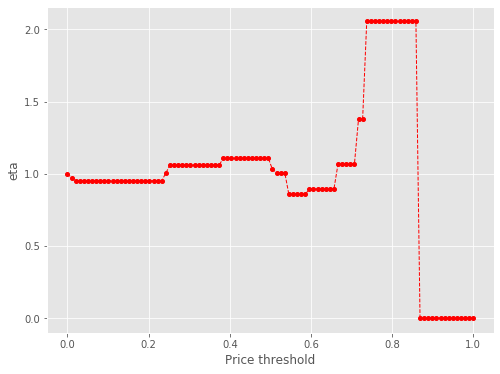

2462 13
Number of cells with price above 66.0th percentile:  13


eta =  1.0
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  0.9797128522566548
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.091886547208097
eta =  1.139130305798396
eta =  1.139130305798396
eta =  1.13913030

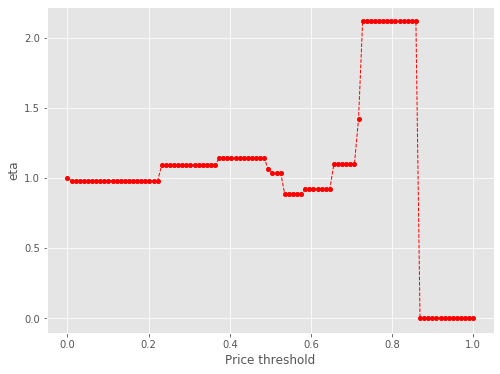

2462 12
Number of cells with price above 67.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


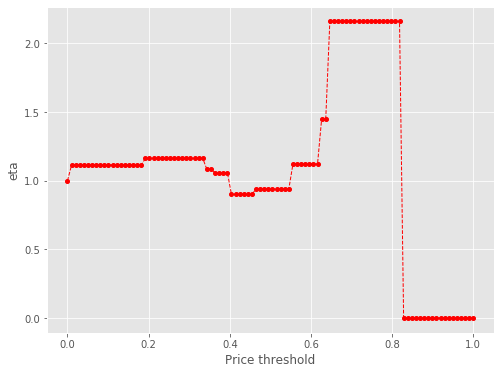

2462 12
Number of cells with price above 68.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


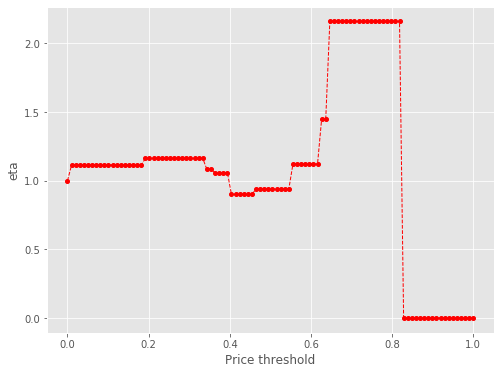

2462 12
Number of cells with price above 69.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


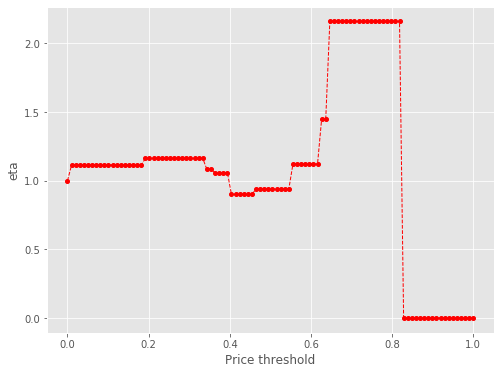

2462 12
Number of cells with price above 70.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


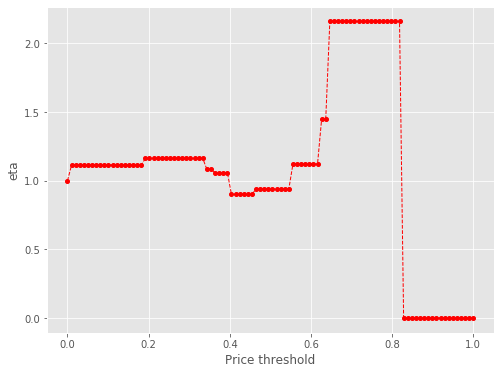

2462 12
Number of cells with price above 71.00000000000001th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


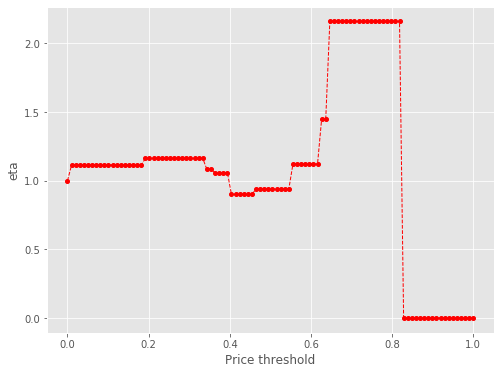

2462 12
Number of cells with price above 72.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


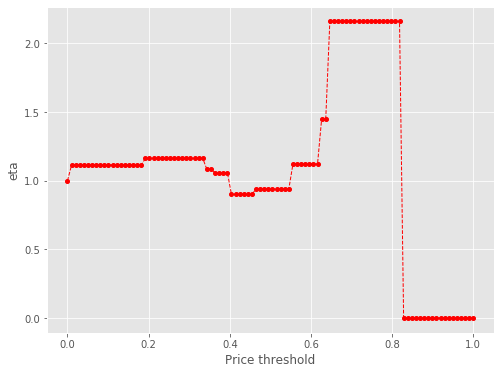

2462 12
Number of cells with price above 73.0th percentile:  12


eta =  1.0
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.11449650241197
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.162718548781453
eta =  1.0826291680102351
eta =  1.0826291680102351
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  1.0594341733165866
eta =  0.9003502065220353


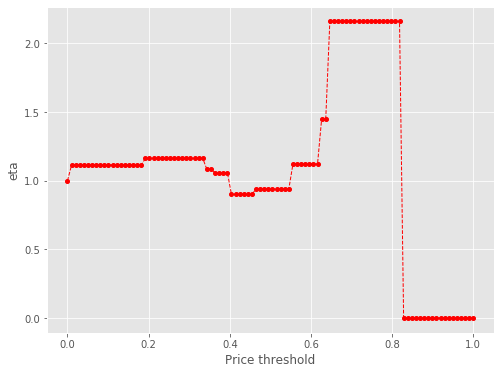

2462 11
Number of cells with price above 74.0th percentile:  11


eta =  1.0
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.055335989003399
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.1009982776574865
eta =  1.025160259609028
eta =  1.0031965184829013
eta =  1.0031965184829013
eta =  1.0031965184829013
eta =  1.0031965184829013
eta =  0.85255716244

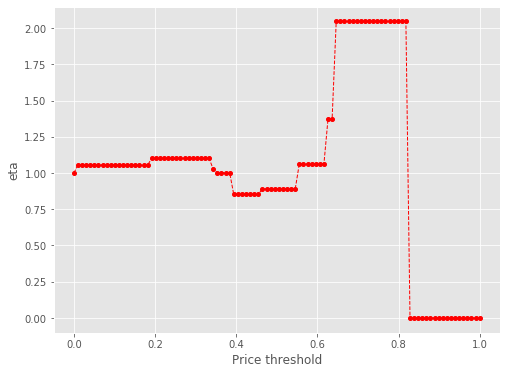

2462 10
Number of cells with price above 75.0th percentile:  10


eta =  1.0
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  0.9714065191476436
eta =  0.9714065191476436
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84

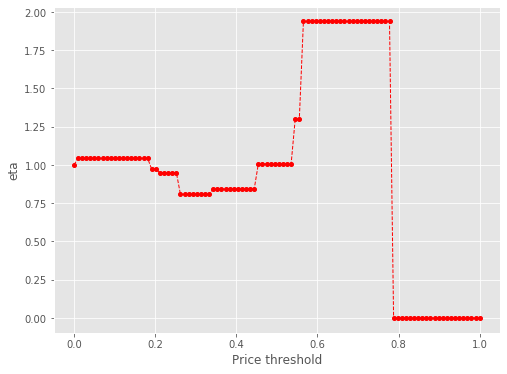

2462 10
Number of cells with price above 76.0th percentile:  10


eta =  1.0
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  0.9714065191476436
eta =  0.9714065191476436
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84

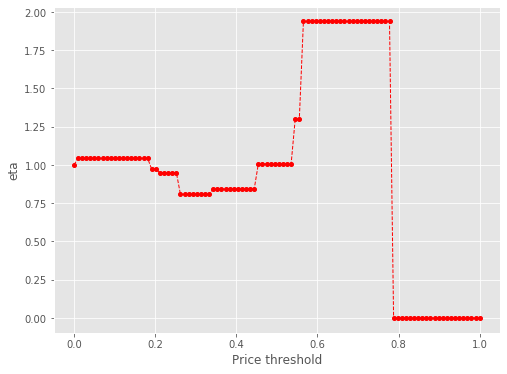

2462 10
Number of cells with price above 77.0th percentile:  10


eta =  1.0
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  0.9714065191476436
eta =  0.9714065191476436
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84

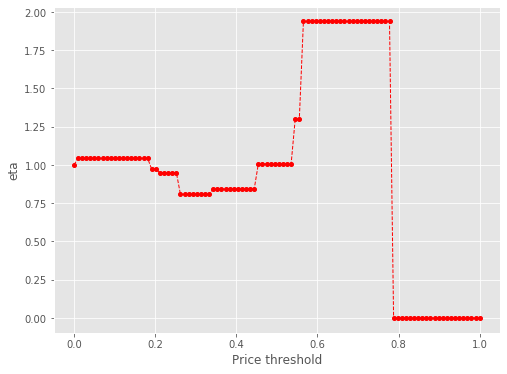

2462 10
Number of cells with price above 78.0th percentile:  10


eta =  1.0
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  1.0432680105008154
eta =  0.9714065191476436
eta =  0.9714065191476436
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.9505944352663122
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.8078537748422865
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84337060721187
eta =  0.84

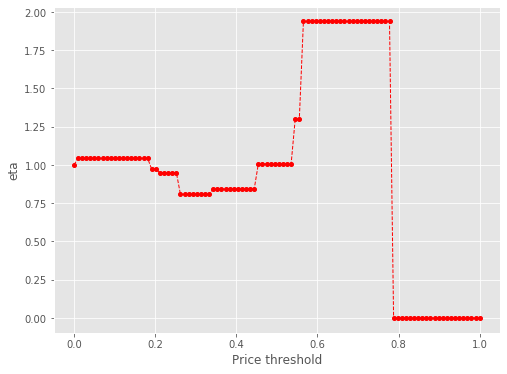

2462 9
Number of cells with price above 79.0th percentile:  9


eta =  1.0
eta =  0.9311188585963879
eta =  0.9311188585963879
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
e

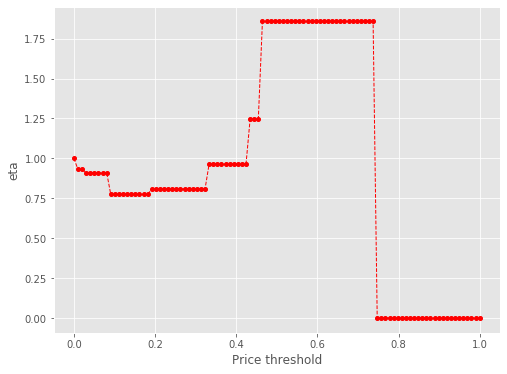

2462 9
Number of cells with price above 80.0th percentile:  9


eta =  1.0
eta =  0.9311188585963879
eta =  0.9311188585963879
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
e

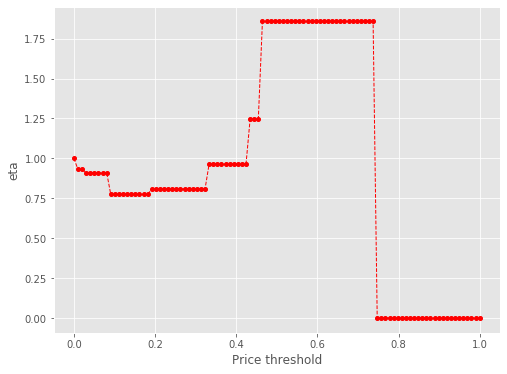

2462 9
Number of cells with price above 81.0th percentile:  9


eta =  1.0
eta =  0.9311188585963879
eta =  0.9311188585963879
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
e

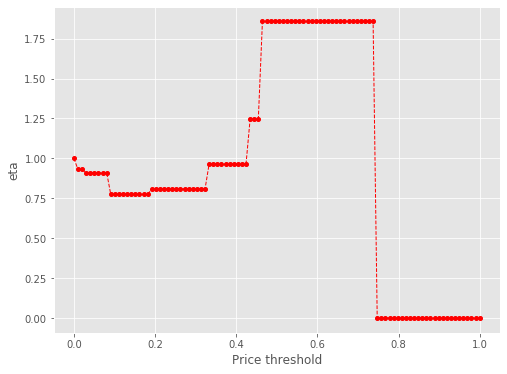

2462 9
Number of cells with price above 82.0th percentile:  9


eta =  1.0
eta =  0.9311188585963879
eta =  0.9311188585963879
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.9111699253674846
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.7743492244667605
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.8083930483088563
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
eta =  0.9650304128407934
e

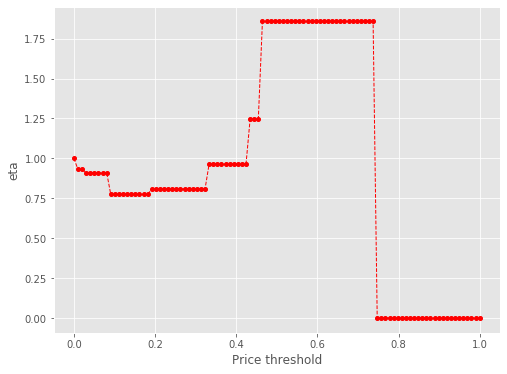

2462 8
Number of cells with price above 83.0th percentile:  8


eta =  1.0
eta =  0.9785753096452421
eta =  0.9785753096452421
eta =  0.9785753096452421
eta =  0.9785753096452421
eta =  0.9785753096452421
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8316330587848373
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  0.8681953338668983
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.036420220610208
eta =  1.

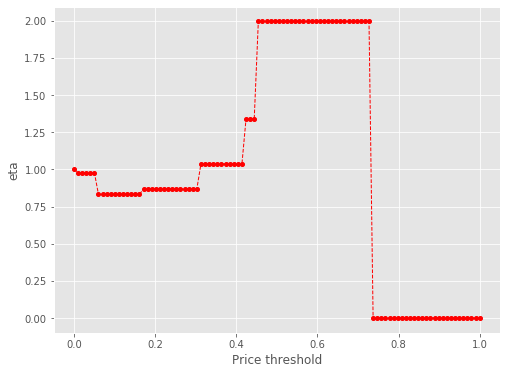

2462 7
Number of cells with price above 84.00000000000001th percentile:  7


eta =  1.0
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8498406311582958
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  0.8872033918182962
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.0591113534081869
eta =  1.3682977613370177
e

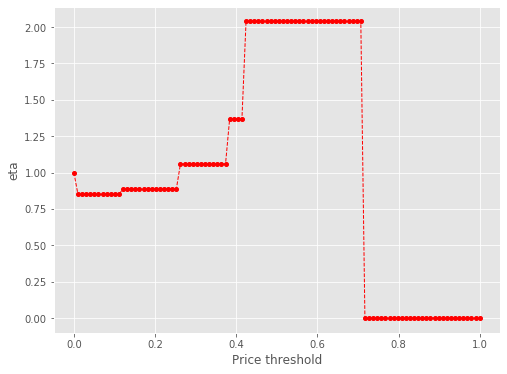

2462 6
Number of cells with price above 85.0th percentile:  6


eta =  1.0
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.0439644320242452
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.2462470192377886
eta =  1.6100639474863512
eta =  1.6100639474863512
eta =  1.6100639474863512
eta =  1.6100639474863512
eta =  2.3988906909944903
eta =  2.3988906909944903
eta =  2.3988906909944903
eta =  2.3988906909944903
eta =  2.3988906909944903
e

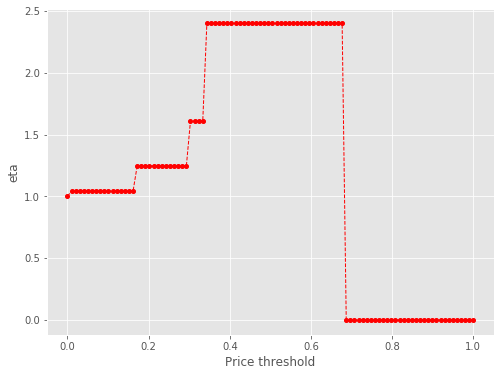

2462 5
Number of cells with price above 86.0th percentile:  5


eta =  1.0
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta = 

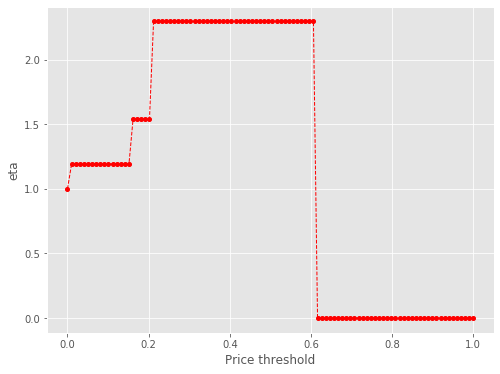

2462 5
Number of cells with price above 87.0th percentile:  5


eta =  1.0
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta = 

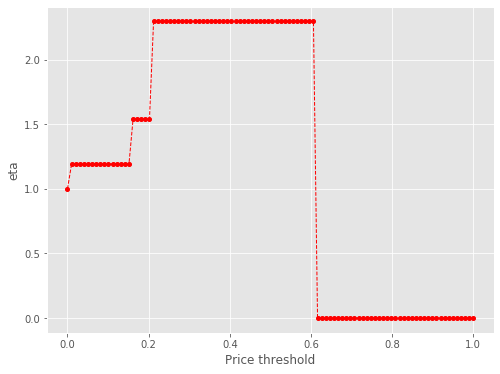

2462 5
Number of cells with price above 88.0th percentile:  5


eta =  1.0
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.1937638687759868
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  1.542259389397434
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta =  2.2978663040684686
eta = 

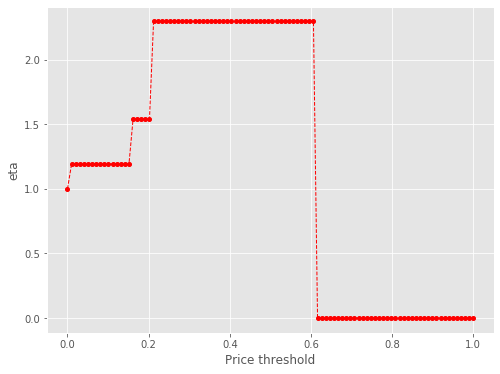

2462 4
Number of cells with price above 89.0th percentile:  4


eta =  1.0
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
e

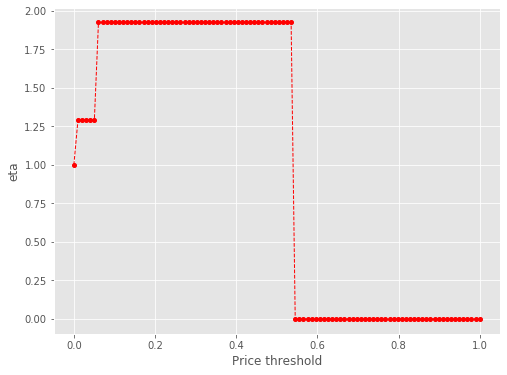

2462 4
Number of cells with price above 90.0th percentile:  4


eta =  1.0
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.2919300288245223
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
eta =  1.9248918183665265
e

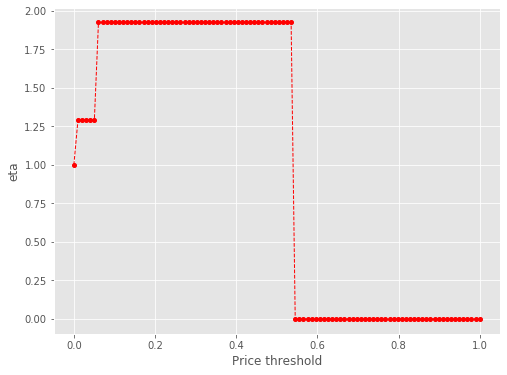

2462 2
Number of cells with price above 91.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

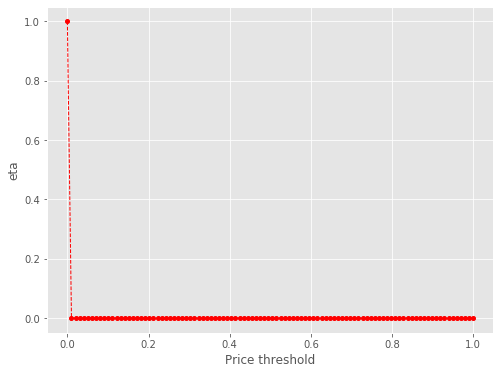

2462 2
Number of cells with price above 92.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

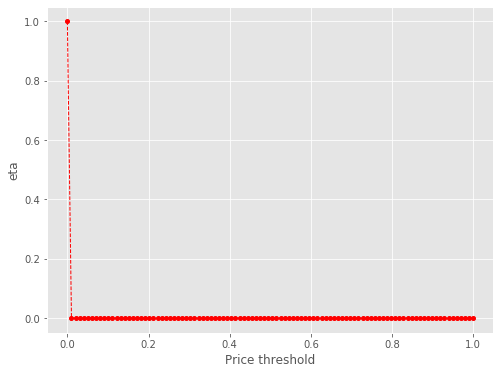

2462 2
Number of cells with price above 93.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

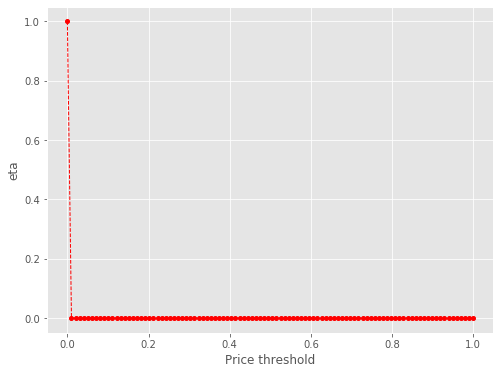

2462 2
Number of cells with price above 94.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

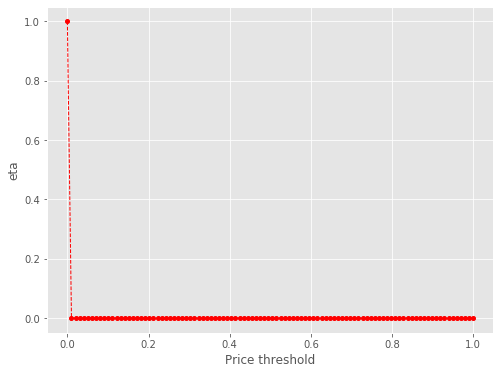

2462 2
Number of cells with price above 95.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

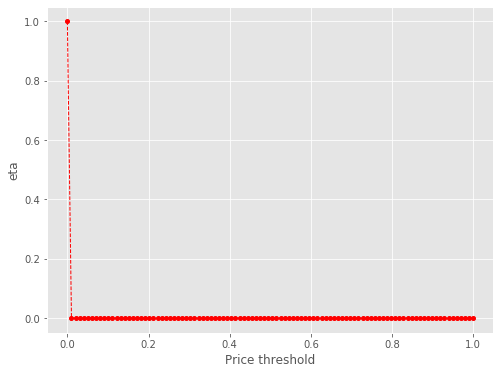

2462 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



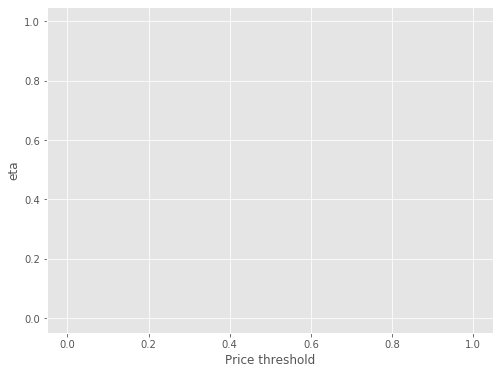

2462 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

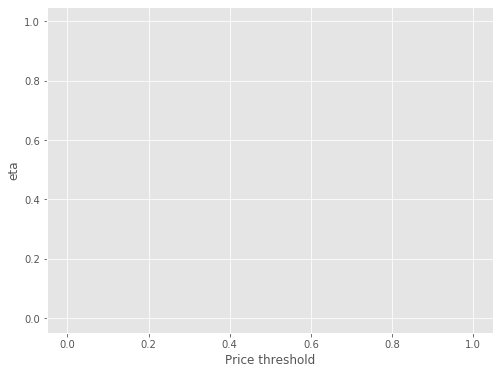

2462 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

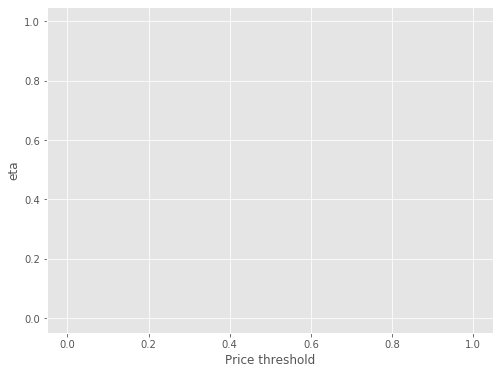

2462 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

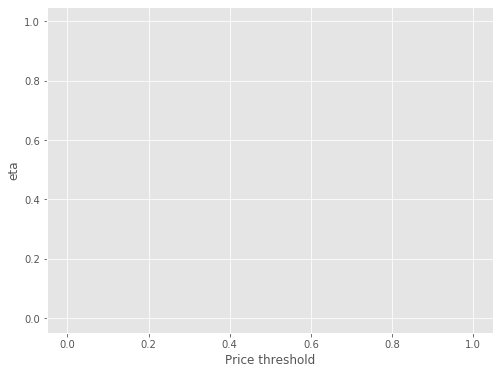

2462 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

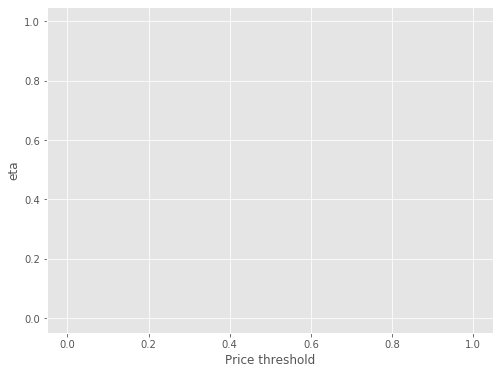


time: 1min 2s


In [35]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

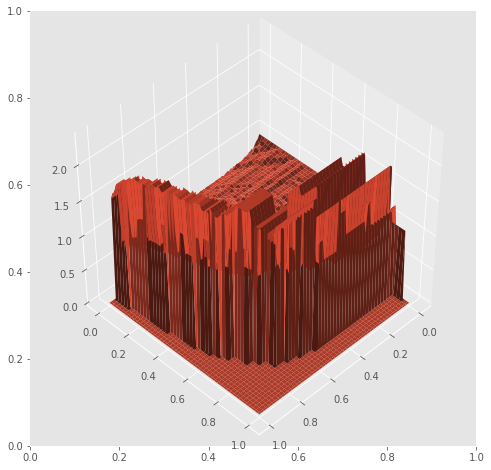

time: 1.24 s


In [36]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [37]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Bremen'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 49 ms


2462 145
Number of cells with price above 5th percentile:  145
total number of cells:  2462
number of cells within urban airbnb territory:  145


Mean travel times in minutes:  8.860810901001113
Mean travel times in minutes:  17.87925754542084
Mean travel times in minutes:  23.878389877641826


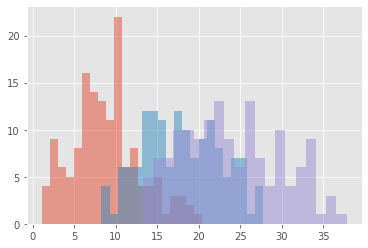

time: 57.5 s


In [40]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.01*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.01*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.1)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

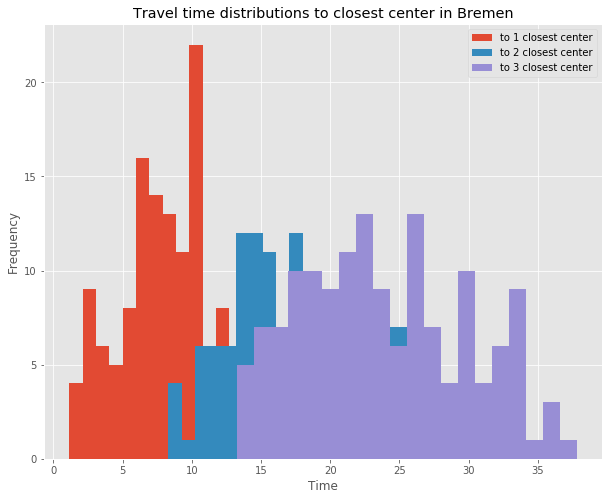

time: 335 ms


In [41]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Bremen')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [42]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Bremen'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 521 ms


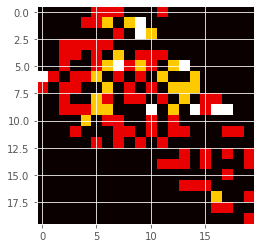

time: 150 ms


In [43]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [44]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.7402687435470336
1.0445728034191364
1.1246371883273492
2.8756949514129753
1.3246445165674179
2.86454922000186
average mutual information =  1.9957279038792954
time: 16 ms


In [45]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Bremen'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 9.01 ms
